In [1]:
#==================================================
# Import libraries & set seed
#==================================================
import os

import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import time

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


# Other sklearn funcitonality
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score # classificatoin problem 
from sklearn.metrics import roc_curve # classificatoin problem
from sklearn.metrics import confusion_matrix # classificatoin problem

from sklearn.metrics import r2_score # Regression problem
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
np.random.seed(42)

## Set metrics

In [2]:
SCORING_METRIC = 'neg_mean_squared_error' # Update
N_JOBS = -1

# Define the scoring function for SKLearn
def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

def rmse(y, y0):
    return np.sqrt(np.mean(np.square(y - y0)))

def scoring_func(estimator, X, y):
    
    return_value = -rmsle(estimator.predict(X), y)
    #return_value = -rmse(estimator.predict(X), y)
    
    return return_value



## Read and investigate data

### Read the data

In [3]:
#Loading the relevant data
base_path = os.path.dirname(os.getcwd())
file_path = os.path.join(base_path, "data")
file_name = "train.csv"

data_destination_train = os.path.join(file_path, file_name) # Full file path + name
raw_data=pd.read_csv(data_destination_train,keep_default_na=False,na_values='')

print(str(raw_data.shape))
raw_data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [4]:
# Load test dataset - we will perform the same transformations we are making to the training dataset in parallel
# in order be able to run the model on it at the end
file_name = "test.csv"
data_destination_test = os.path.join(file_path, file_name) # Full file path + name
raw_data_test=pd.read_csv(data_destination_test,keep_default_na=False,na_values='')

print(str(raw_data_test.shape))
raw_data_test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,Rec,468,LwQ,144,270,882,GasA,TA,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1,1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,TA,TA,CBlock,TA,TA,No,ALQ,923,Unf,0,406,1329,GasA,TA,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,GLQ,791,Unf,0,137,928,GasA,Gd,Y,SBrkr,928,701,0,1629,0,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
3,1464,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20,TA,TA,PConc,TA,TA,No,GLQ,602,Unf,0,324,926,GasA,Ex,Y,SBrkr,926,678,0,1604,0,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998,Fin,2,470,TA,TA,Y,360,36,0,0,0,0,NA,NA,NA,0,6,2010,WD,Normal
4,1465,120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0,Gd,TA,PConc,Gd,TA,No,ALQ,263,Unf,0,1017,1280,GasA,Ex,Y,SBrkr,1280,0,0,1280,0,0,2,0,2,1,Gd,5,Typ,0,NA,Attchd,1992,RFn,2,506,TA,TA,Y,0,82,0,0,144,0,NA,NA,NA,0,1,2010,WD,Normal


In [5]:
# We see that the data contains many variables which have missing data-points
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null object
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-

### Plot data
* Plot the data and do a first selection and data exclusion
* Select which ivs that shall be included in the dummy data creation

In [6]:
# Select the type of variable based on variable description in data_description.txt
categorical_variables = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "OverallQual",
    "OverallCond",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Heating",
    "HeatingQC",
    "CentralAir",
    "Electrical",
    "BsmtFullBath", # This is a numerical variable but shall be grouped as categorical (probably non-linear)
    "BsmtHalfBath", # This is a numerical variable but shall be grouped as categorical (probably non-linear)
    "FullBath", # 
    "HalfBath", #
    "BedroomAbvGr", #
    "KitchenAbvGr", #
    "KitchenQual", 
    "TotRmsAbvGrd", #
    "Functional", 
    "Fireplaces", #
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageCars",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "MoSold",
    "SaleType",
    "SaleCondition"
]

continous_variables = [
    "LotFrontage",
    "LotArea",
    "YearBuilt", # Need to investigate if this variable is linear or if binning shall be performed for some models
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageYrBlt", # Need to investigate if this variable is linear or if binning shall be performed for some models
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold", # Need to investigate if this variable is linear or if binning shall be performed for some models
    
    # Quality variables is included in both continous and and categorical variables
    "OverallQual",
]

# THis is done below
# Add total area 1stFlrSF + 2ndFlrSF
# Add a total "PoarchArea" variable WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


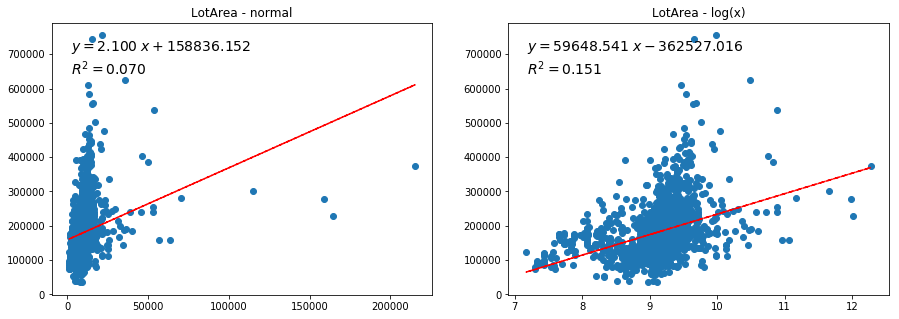

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


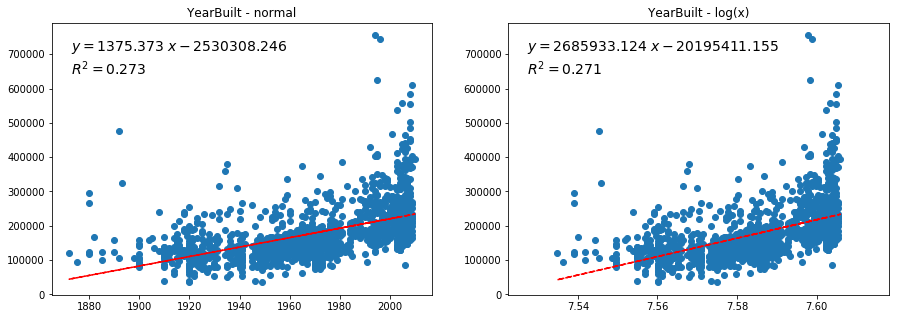

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


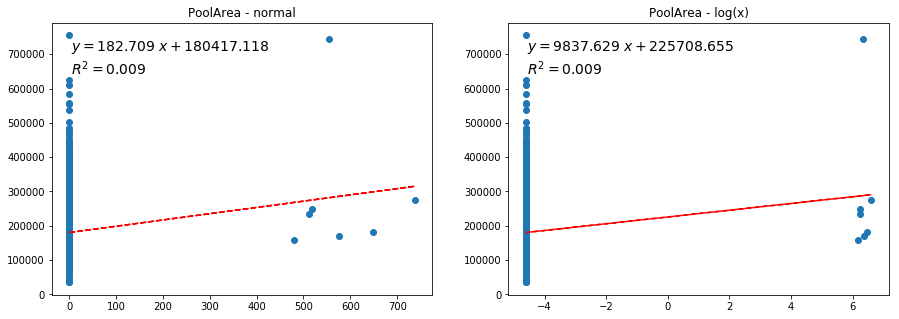

(0.008538415958697199, 0.008781398108915872)

In [7]:
# Define a function to plot continous variables
def plot_continous_variable(data,x_variable, y_variable="SalePrice"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    
    # clean data for plotting
    x_raw = data[x_variable].copy()
    x_raw.loc[x_raw=="NA"] = 0.0
    x_raw = x_raw.fillna(0).astype(float)
    x_raw_log = x_raw.copy()
    x_raw_log.loc[x_raw_log==0] = 0.01 # Todo: look into this variable

    x = x_raw
    y = data[y_variable]
    ax1.scatter(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    y_hat = np.poly1d(z)(x)
    ax1.plot(x,p(x),"r--")
    r2_norm = r2_score(y,y_hat)

    text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_norm:0.3f}$"
    ax1.text(0.05, 0.95, text,transform=ax1.transAxes,
         fontsize=14, verticalalignment='top')
    ax1.set_title("{} - normal".format(x_variable))

    # logarithmic
    x_log = np.log(x_raw_log)
    y = data['SalePrice']
    ax2.scatter(x_log, y)

    z = np.polyfit(x_log, y, 1)
    p = np.poly1d(z)
    y_hat = np.poly1d(z)(x_log)
    ax2.plot(x_log,p(x_log),"r--")
    r2_log = r2_score(y,y_hat)
    
    text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_log :0.3f}$"

    ax2.text(0.05, 0.95, text,transform=ax2.transAxes,
         fontsize=14, verticalalignment='top')
    ax2.set_title("{} - log(x)".format(x_variable))

    plt.show()
    
    return r2_norm, r2_log

# Test to plot some of the variables
plot_continous_variable(raw_data,x_variable='LotArea')
plot_continous_variable(raw_data,x_variable='YearBuilt')
plot_continous_variable(raw_data,x_variable="PoolArea")

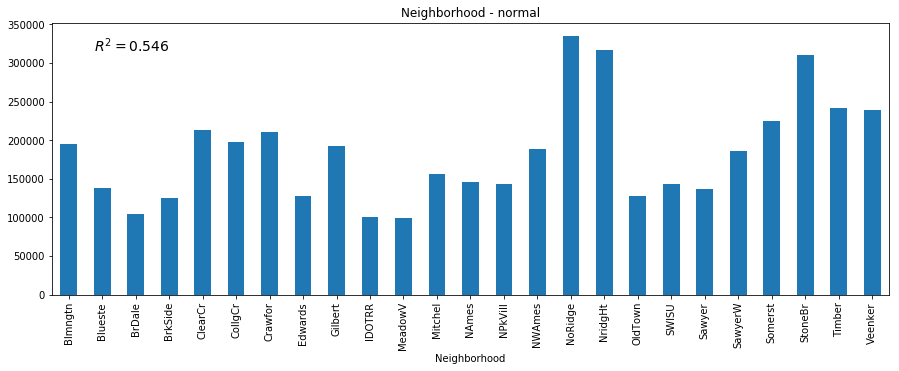

0.5455749908095633

In [8]:
# Functionallity to plot categorical variables
def plot_categorical_variable(data,x_variable, y_variable="SalePrice"):
    """
    Funciton that plots and perform SFA on categorical variables
    """
    # perform SFA evaluation
    x_data = data[x_variable].astype("category")
    independent_data = pd.get_dummies(x_data, drop_first=True)
    dependent_data = data[y_variable]
    
    act_model = LinearRegression()
    trained_model = act_model.fit(independent_data, dependent_data)
    model_score = trained_model.score(independent_data, dependent_data)
    
    
    plt.figure(figsize=(15,5))
    
    data_to_plot = data.groupby(x_variable)[y_variable].mean()
    
    data_to_plot.plot(kind="bar")
    plt.title("{} - normal".format(x_variable))
    
    text = f"$R^2 = {model_score:0.3f}$"
    plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
    
    plt.show()
    
    return model_score
    
plot_categorical_variable(raw_data, "Neighborhood")

LotFrontage


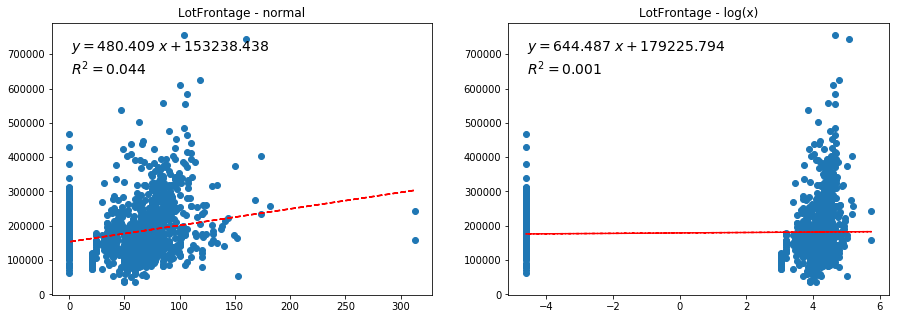

LotArea


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


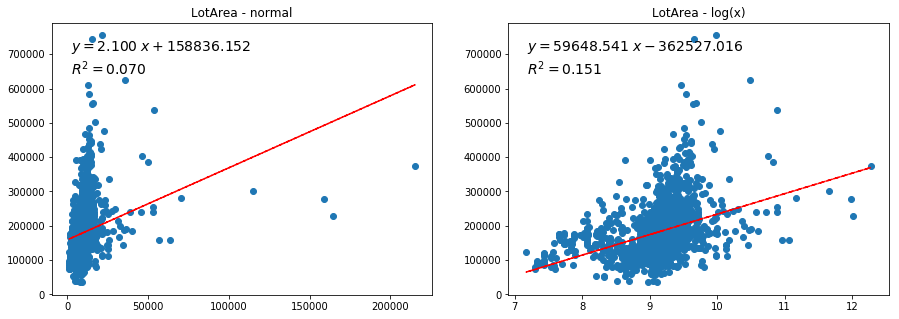

YearBuilt


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


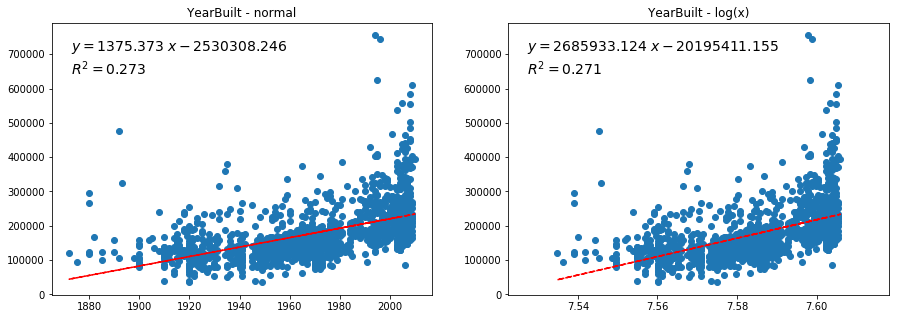

YearRemodAdd


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


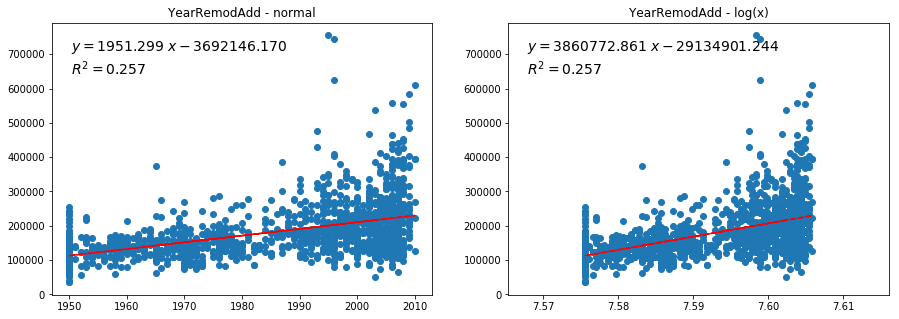

MasVnrArea


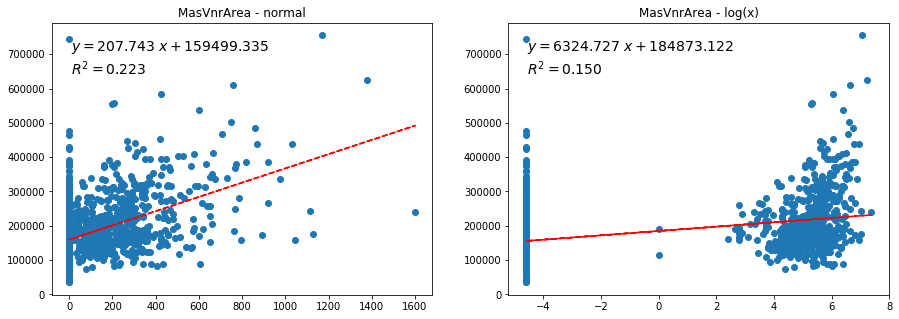

BsmtFinSF1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


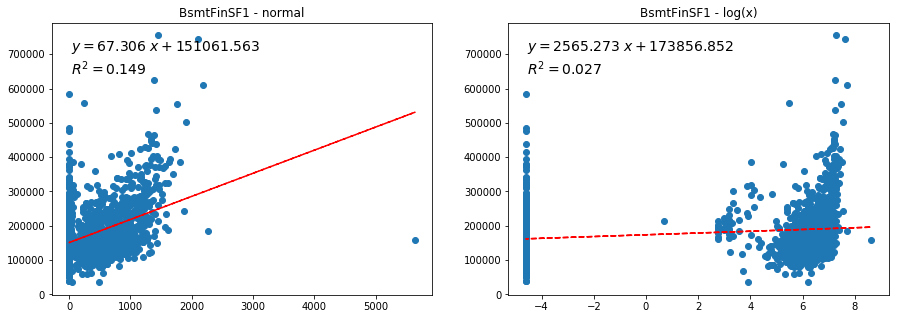

BsmtFinSF2


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


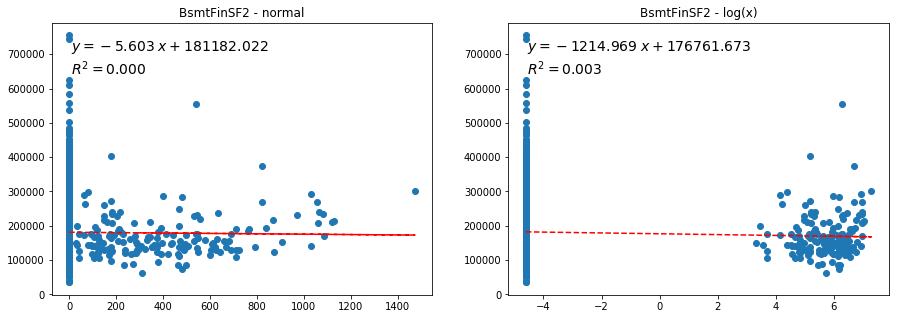

BsmtUnfSF


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


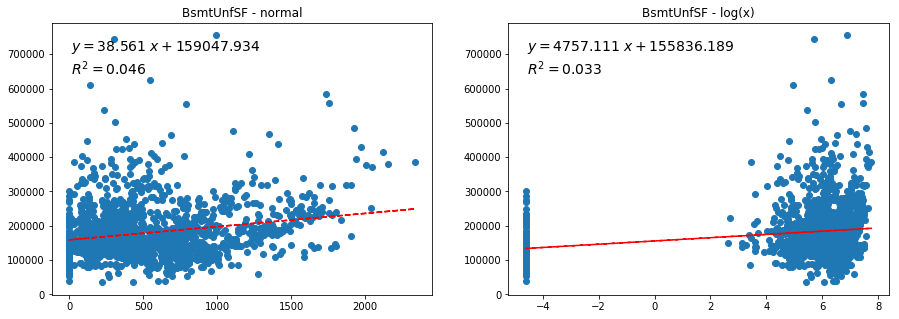

TotalBsmtSF


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


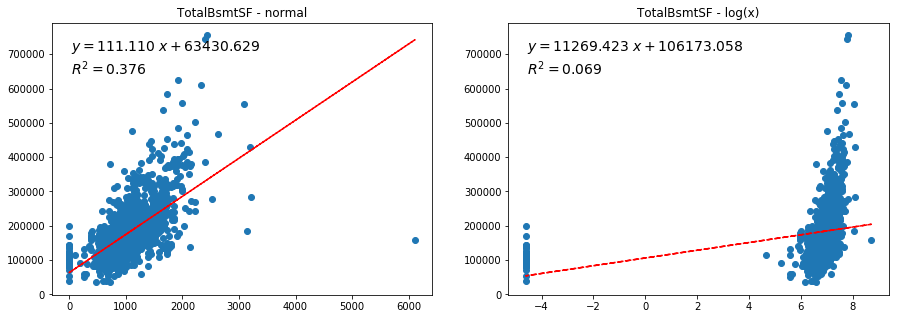

1stFlrSF


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


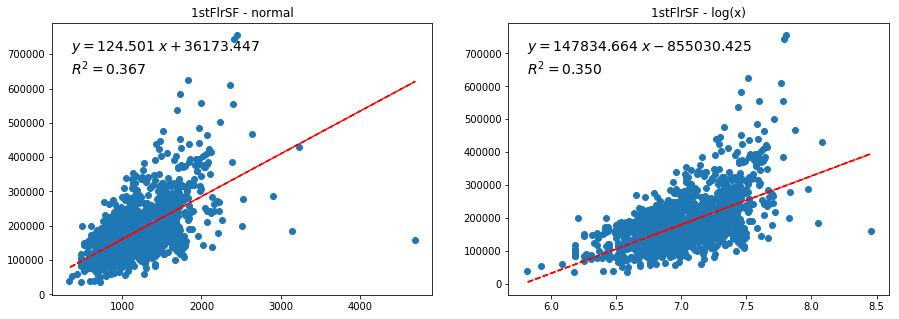

2ndFlrSF


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


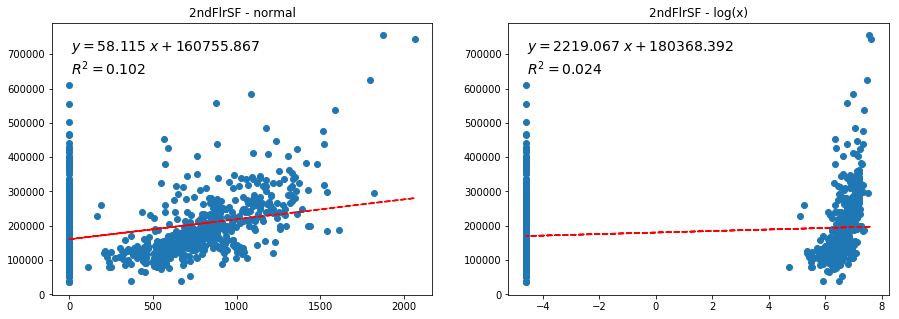

LowQualFinSF


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


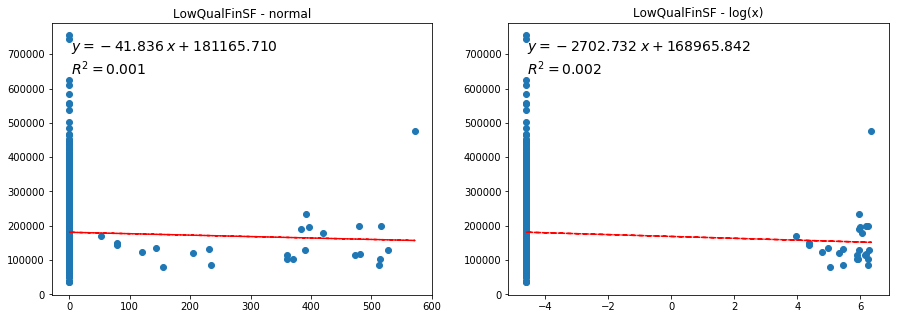

GrLivArea


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


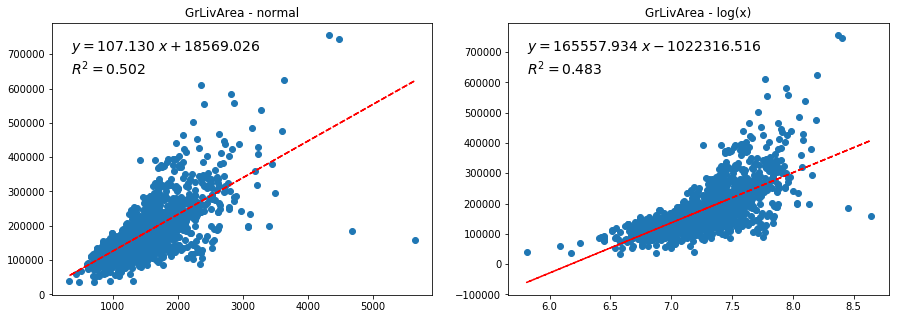

GarageYrBlt


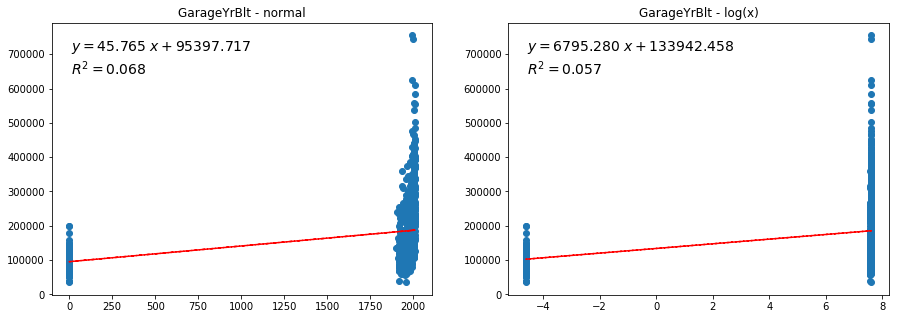

GarageArea


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


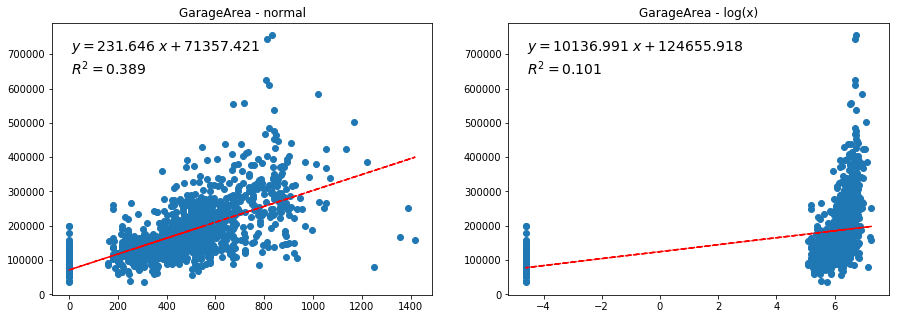

WoodDeckSF


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


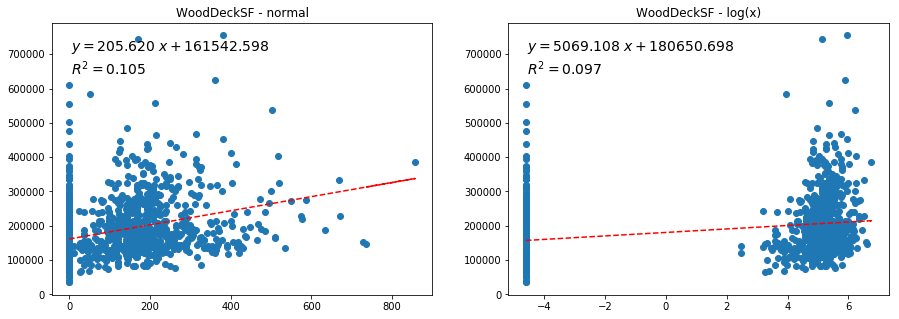

OpenPorchSF


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


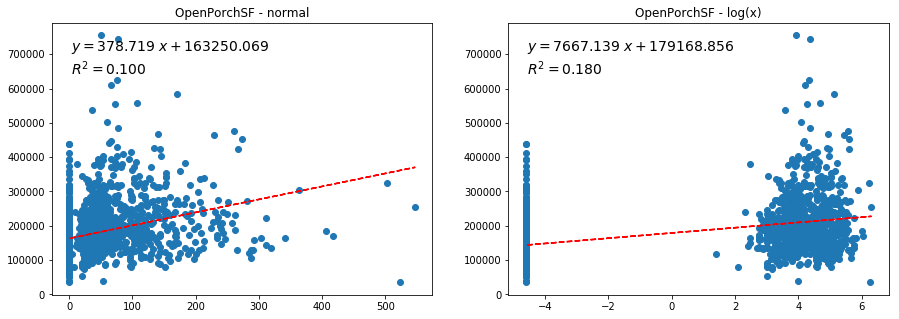

EnclosedPorch


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


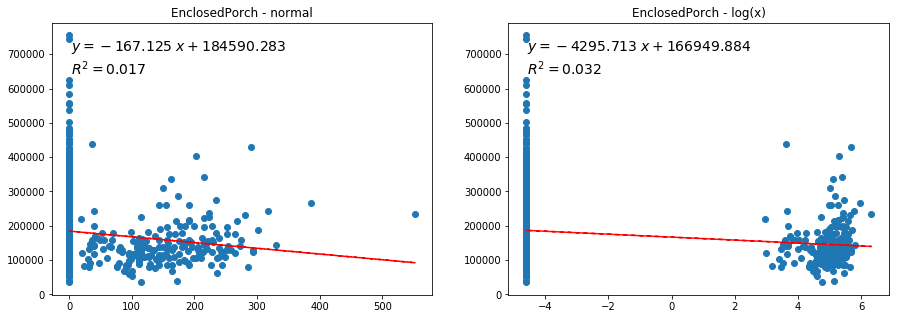

3SsnPorch


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


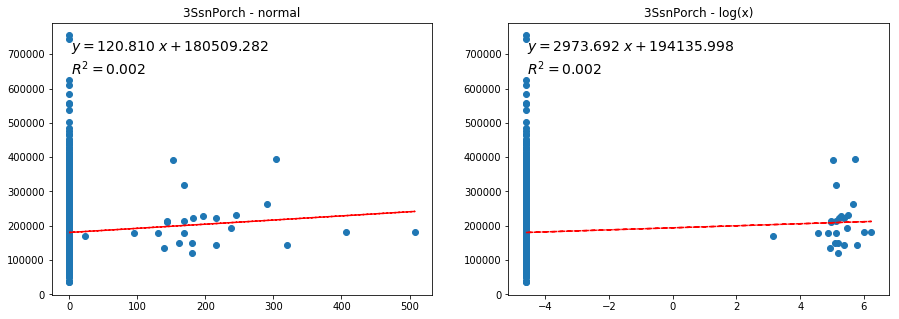

ScreenPorch


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


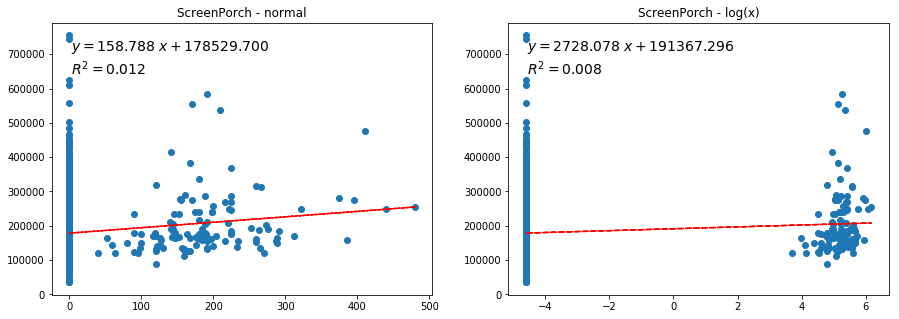

PoolArea


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


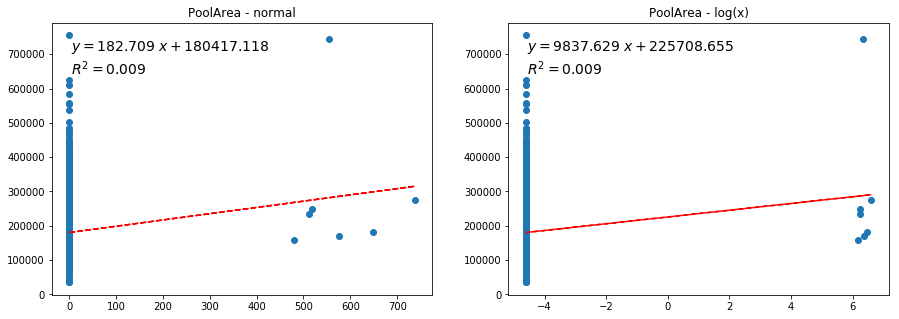

MiscVal


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


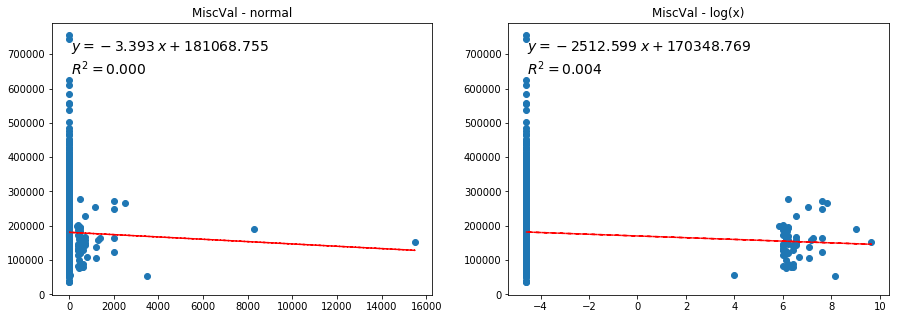

YrSold


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


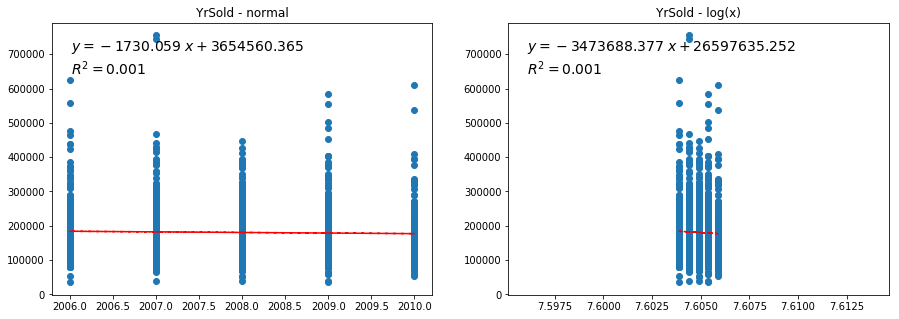

OverallQual


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


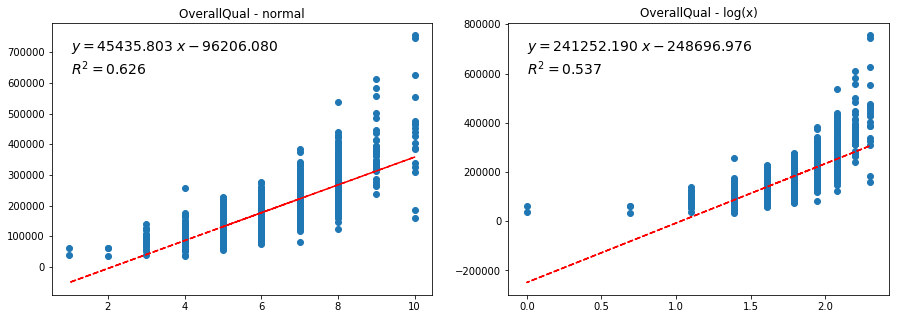

In [9]:
# Plot variable overview for all contionus variables
continous_variables_r2 =[]
for variable_to_plot in continous_variables:
    print(variable_to_plot)
    normal_r2, log_r2 = plot_continous_variable(raw_data,x_variable=variable_to_plot)
    continous_variables_r2.append([variable_to_plot, normal_r2])

continous_overview = pd.DataFrame(continous_variables_r2, columns=["variable", "R2"])

MSSubClass


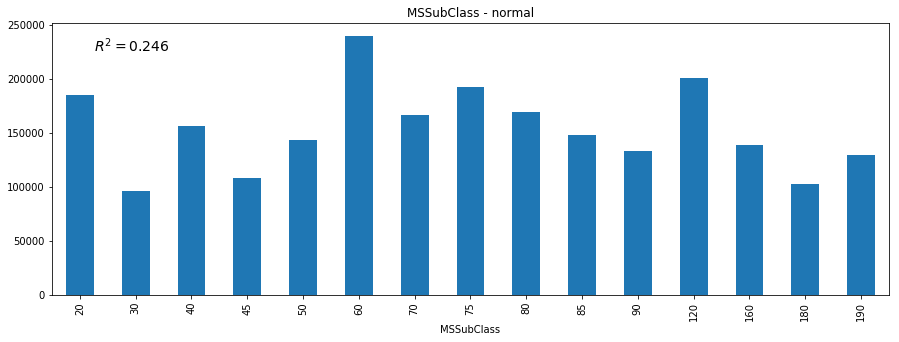

MSZoning


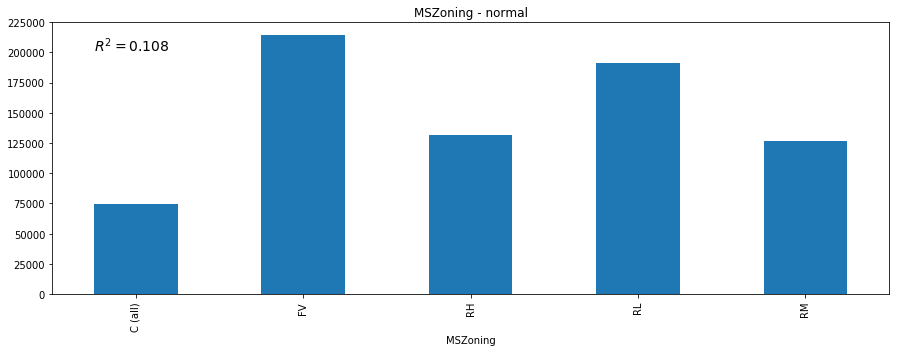

Street


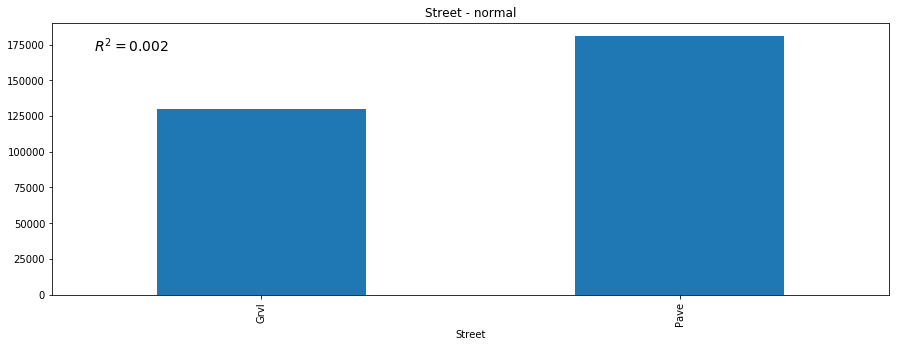

Alley


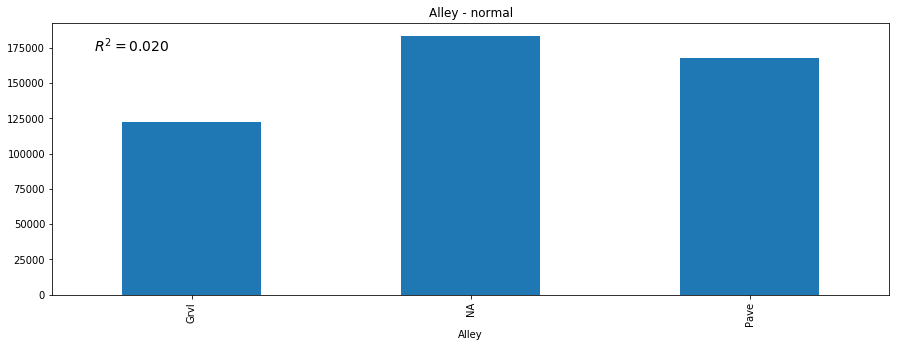

LotShape


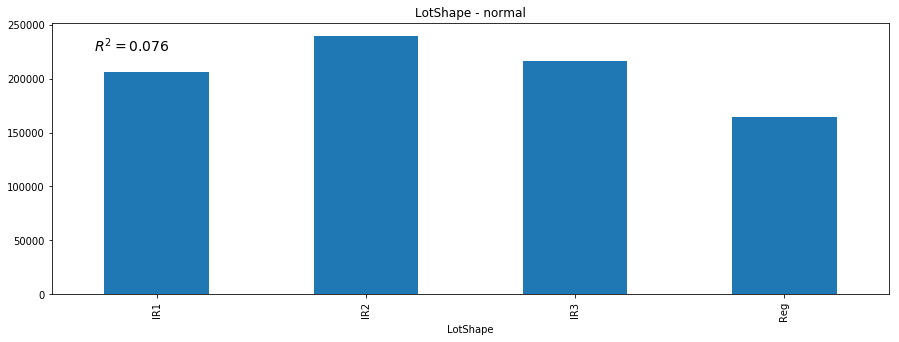

LandContour


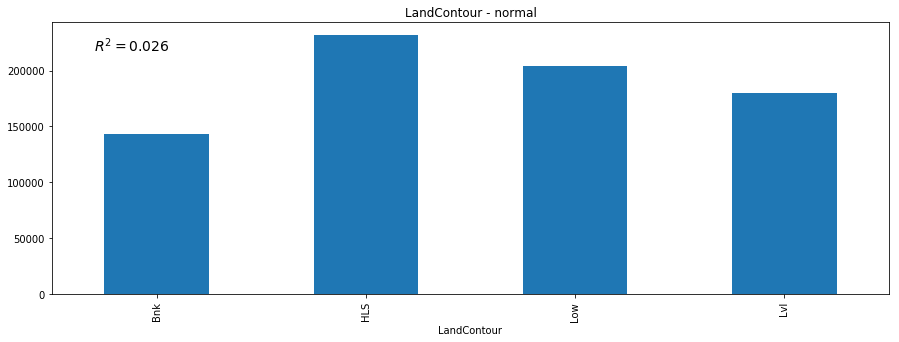

Utilities


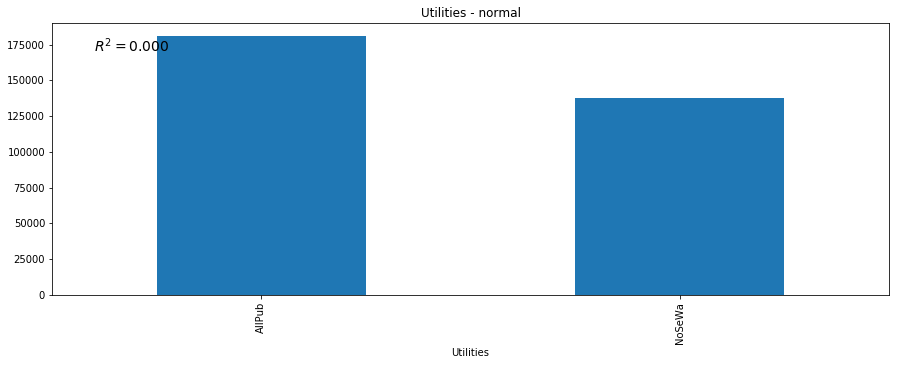

LotConfig


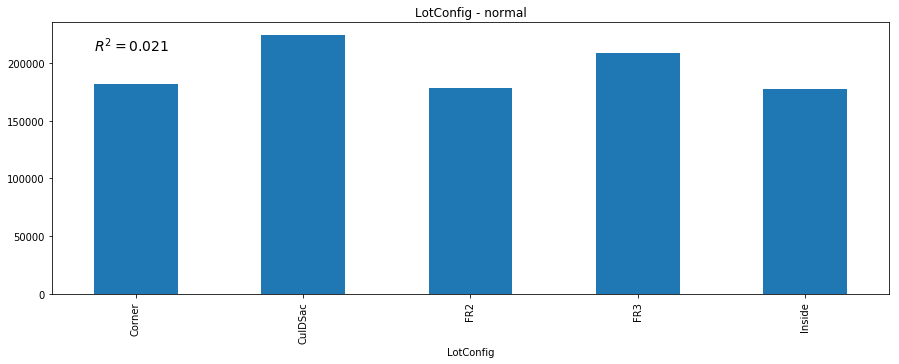

LandSlope


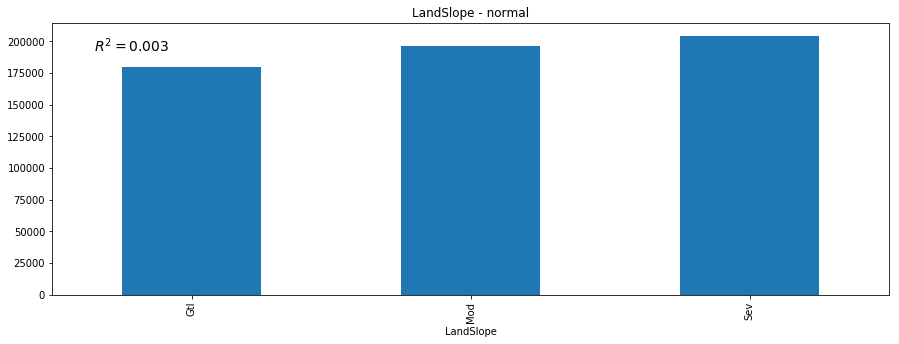

Neighborhood


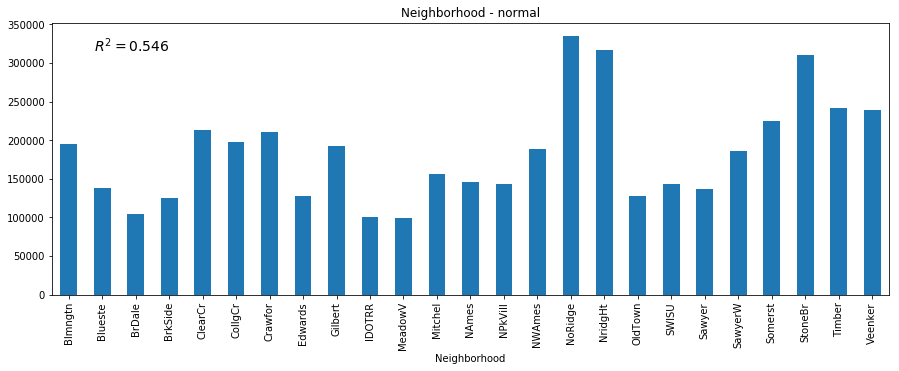

Condition1


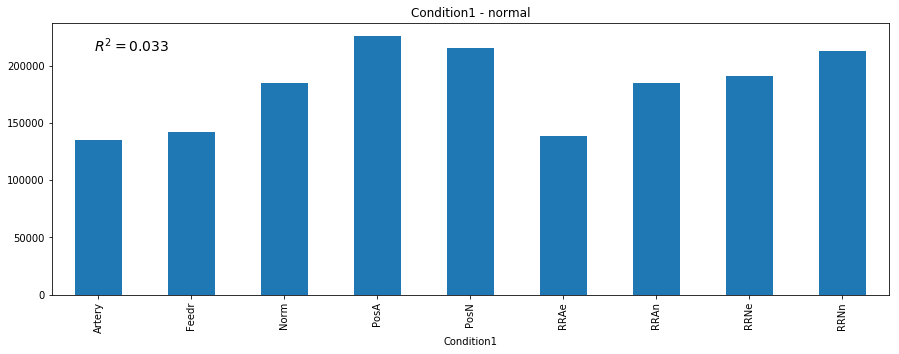

Condition2


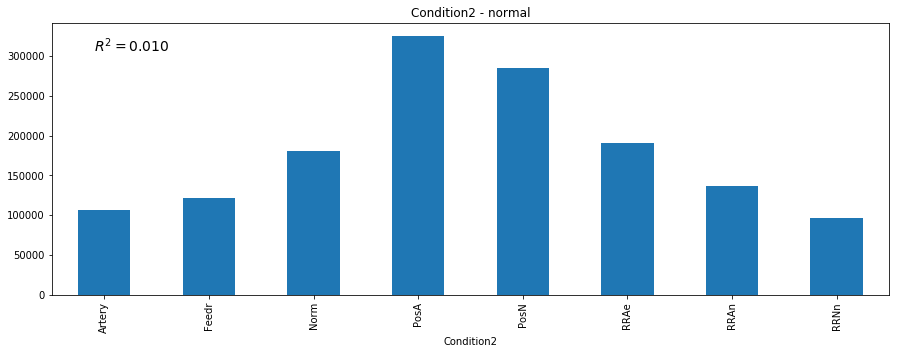

BldgType


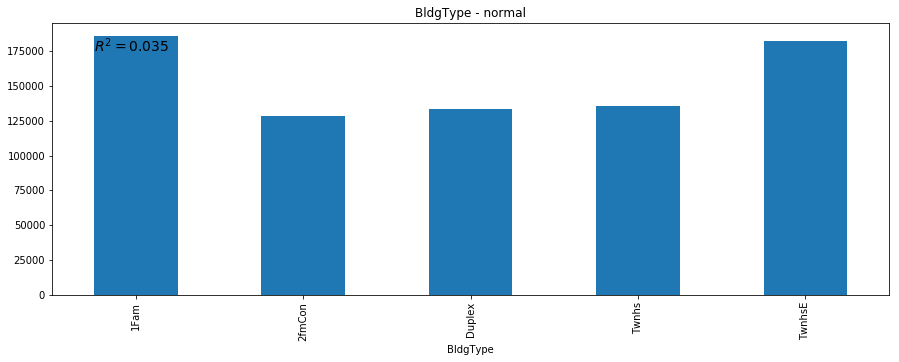

HouseStyle


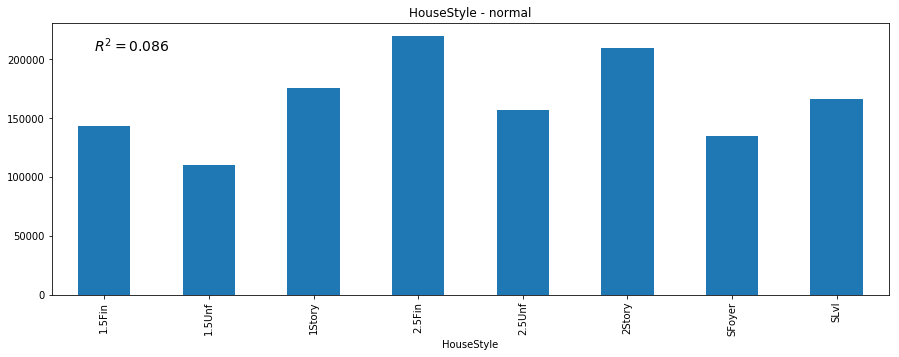

OverallQual


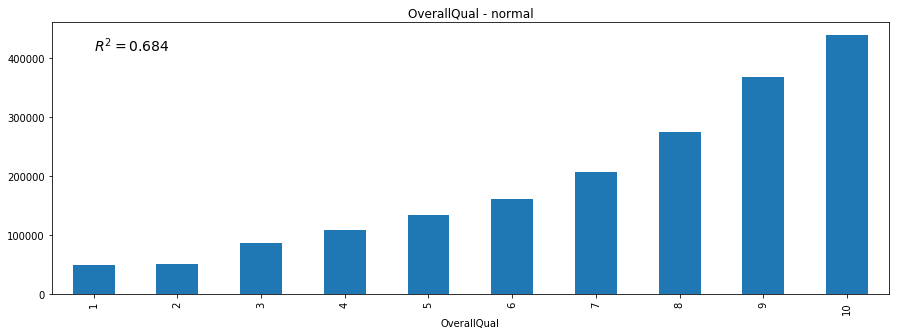

OverallCond


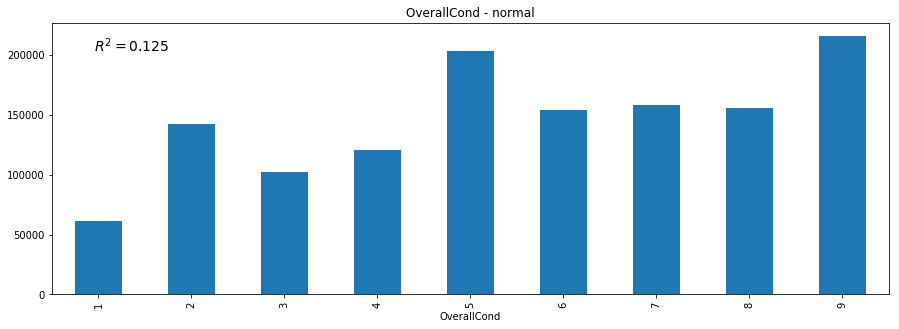

RoofStyle


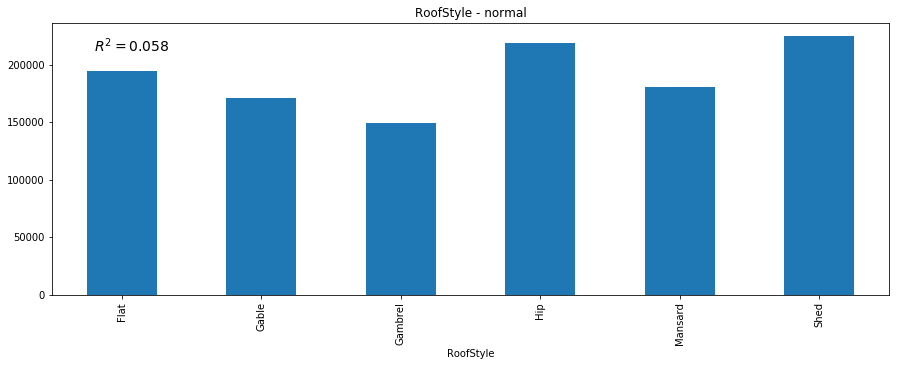

RoofMatl


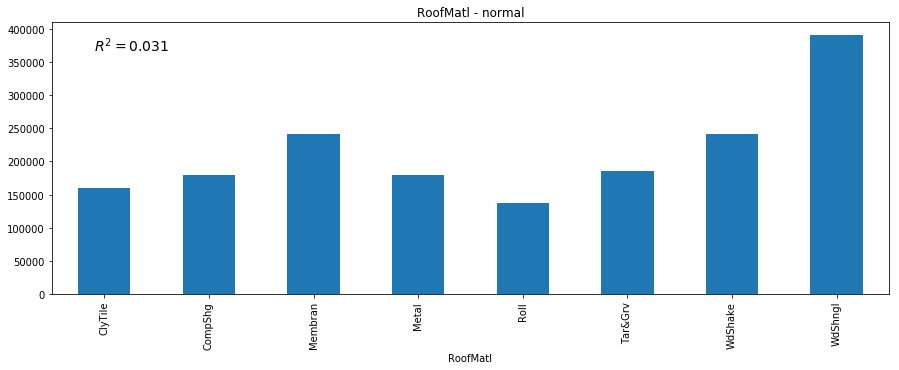

Exterior1st


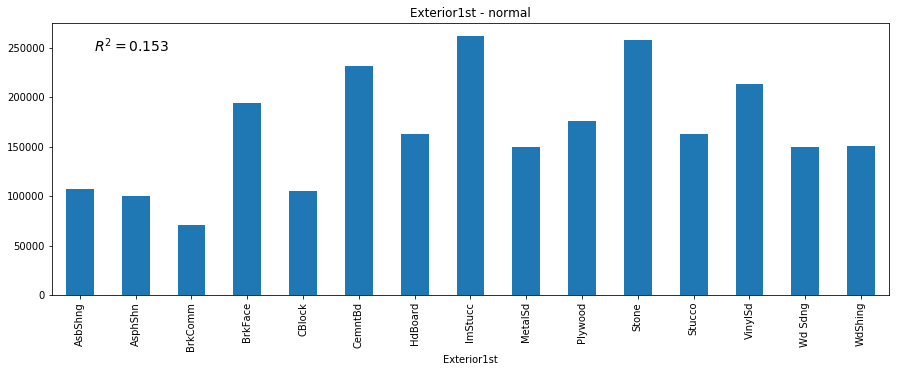

Exterior2nd


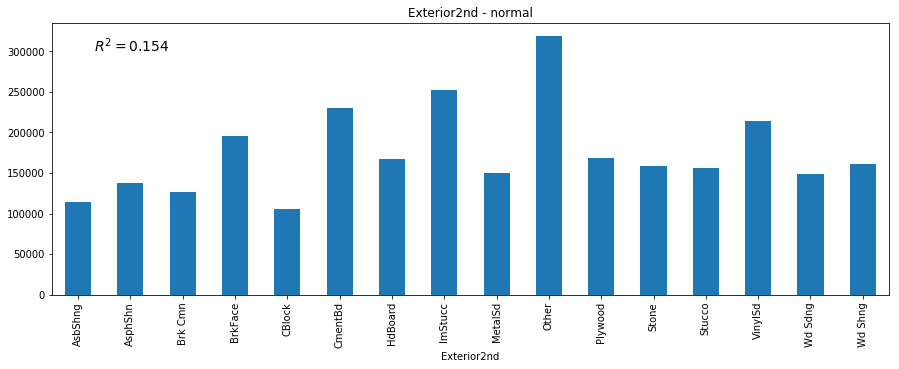

MasVnrType


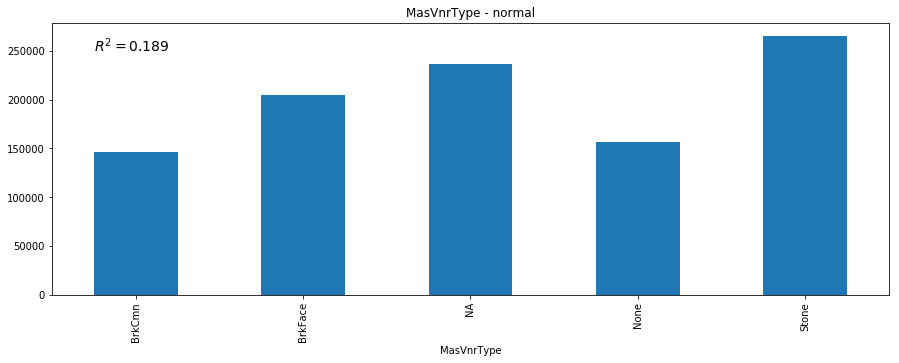

ExterQual


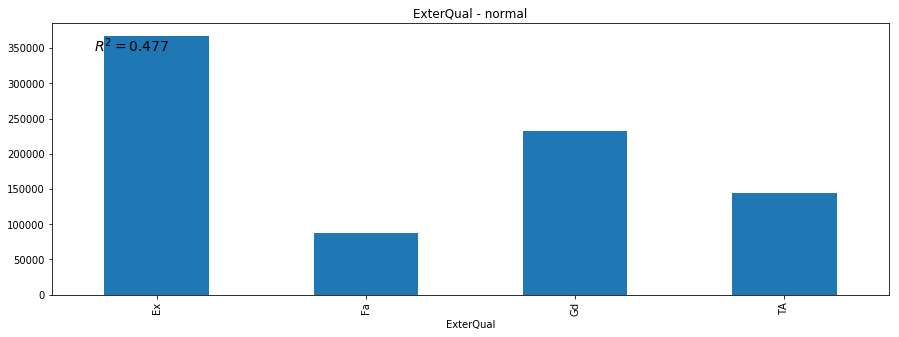

ExterCond


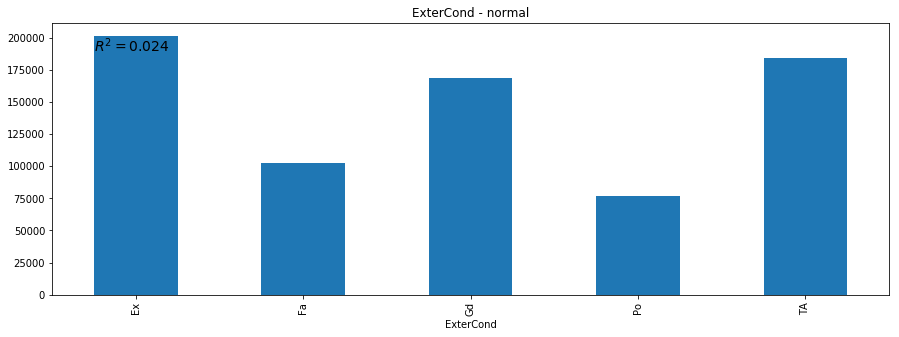

Foundation


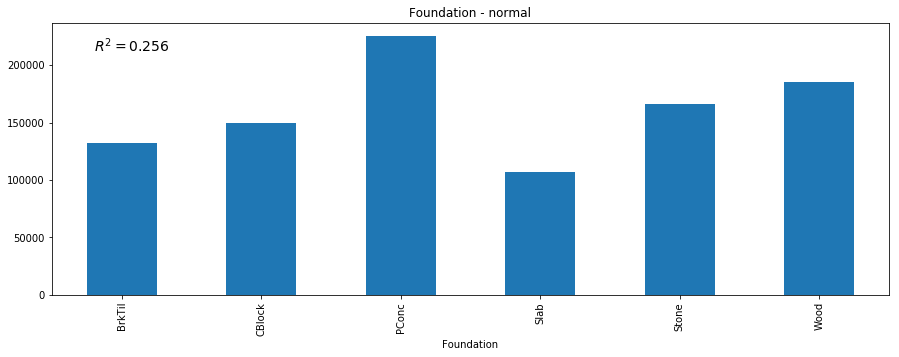

BsmtQual


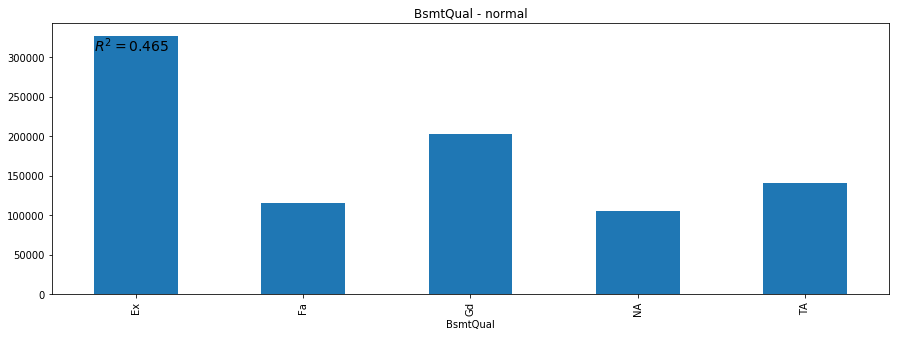

BsmtCond


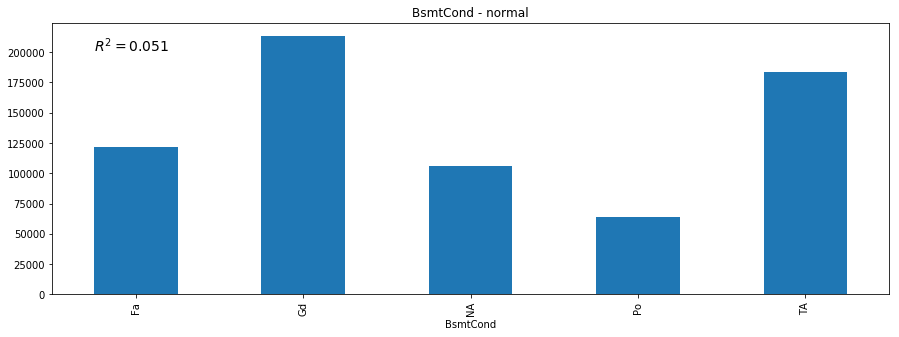

BsmtExposure


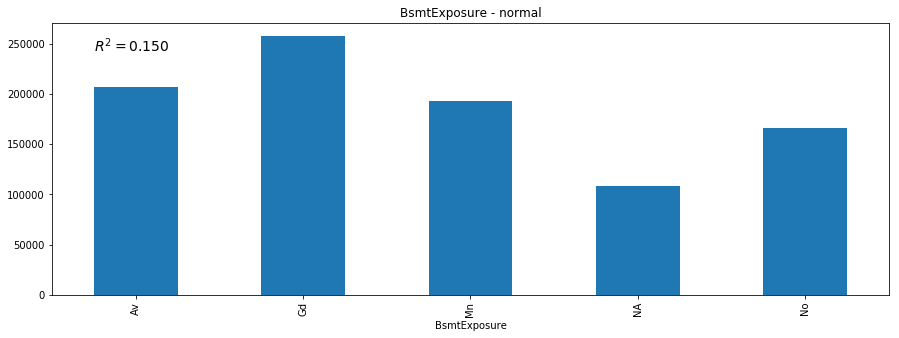

BsmtFinType1


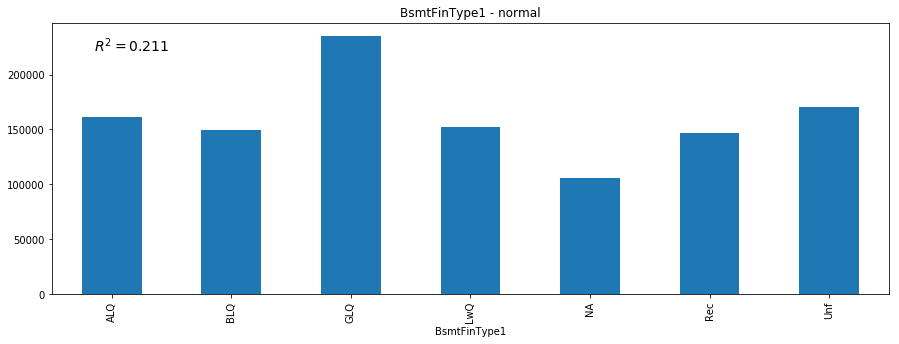

BsmtFinType2


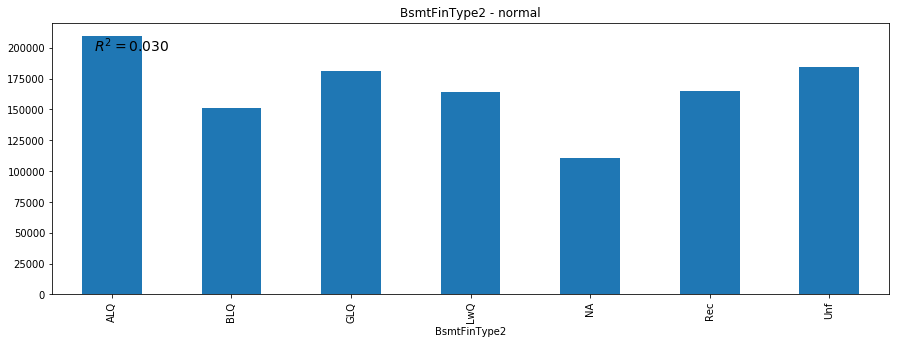

Heating


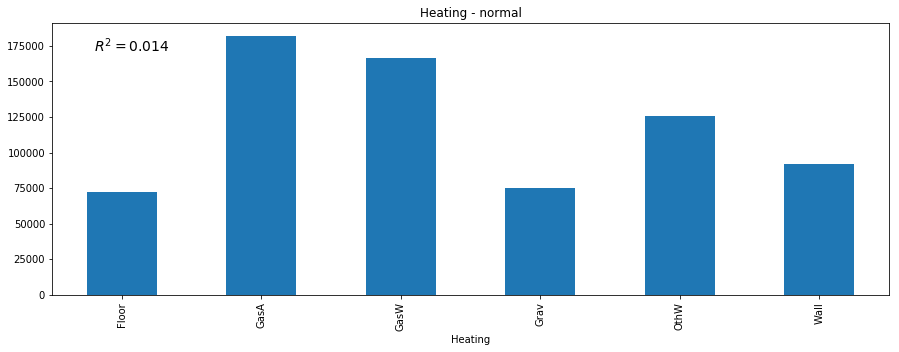

HeatingQC


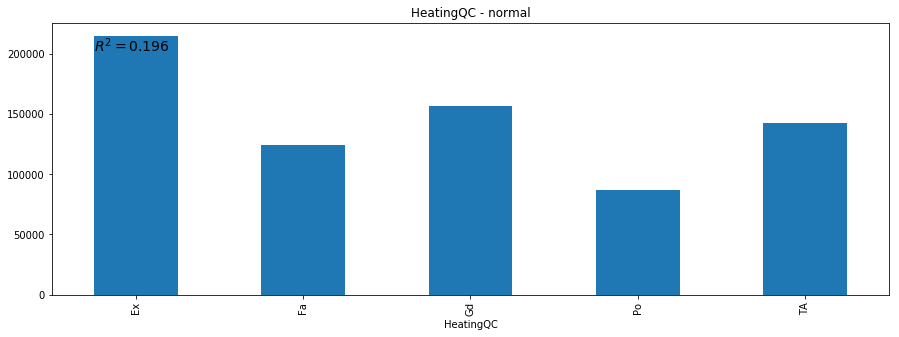

CentralAir


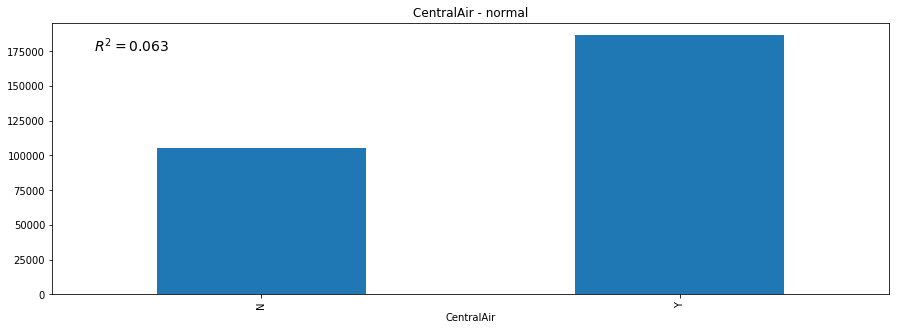

Electrical


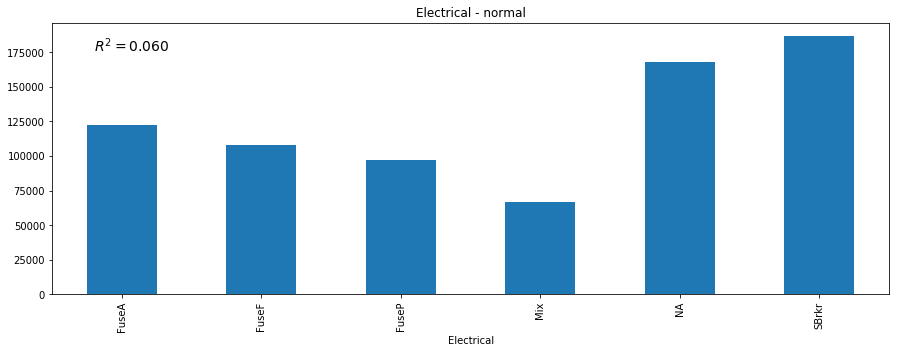

BsmtFullBath


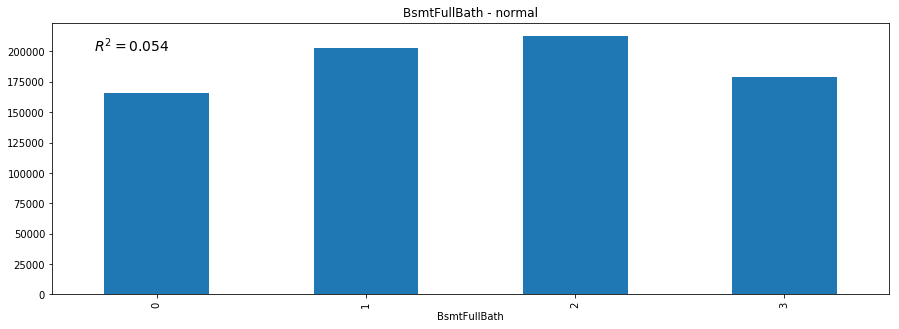

BsmtHalfBath


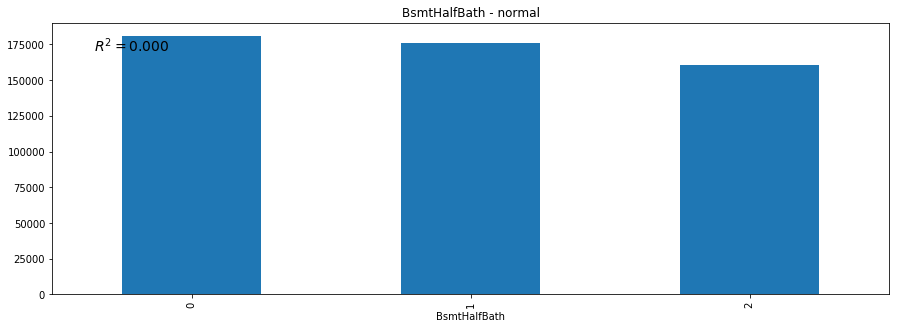

FullBath


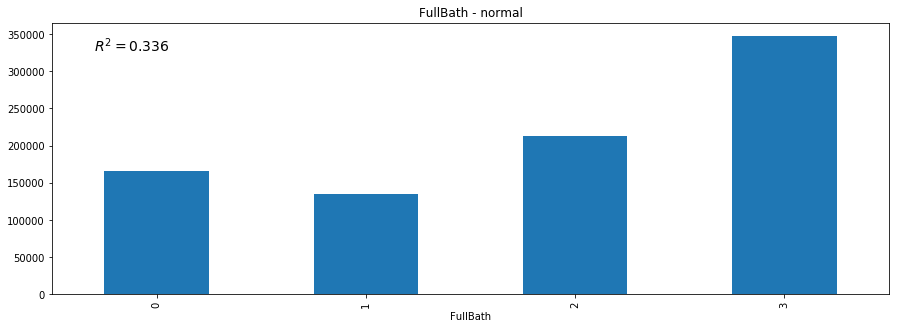

HalfBath


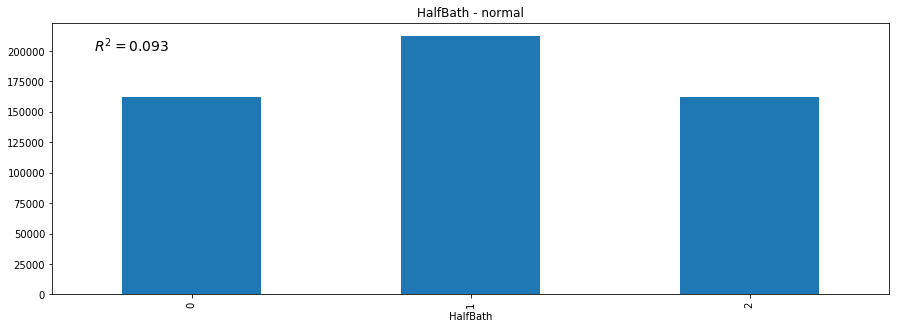

BedroomAbvGr


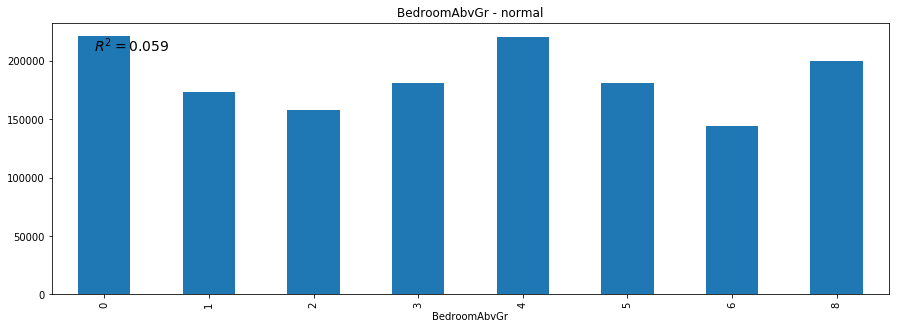

KitchenAbvGr


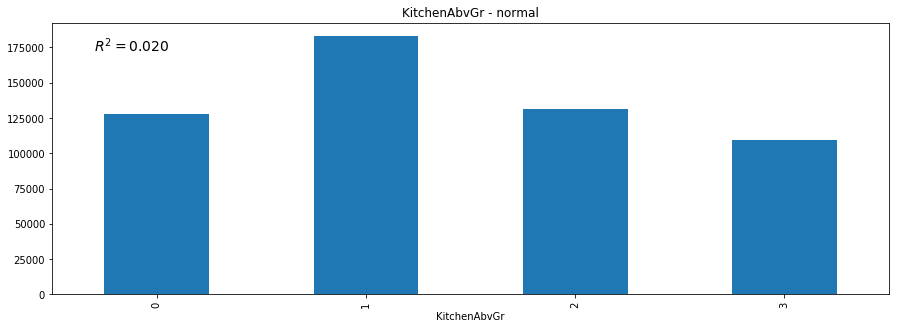

KitchenQual


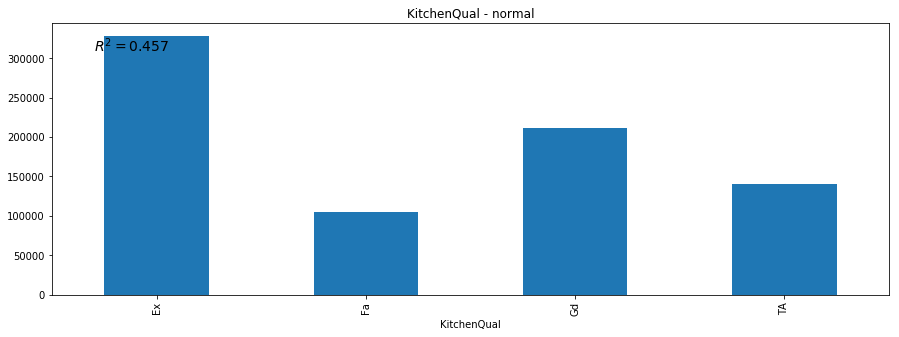

TotRmsAbvGrd


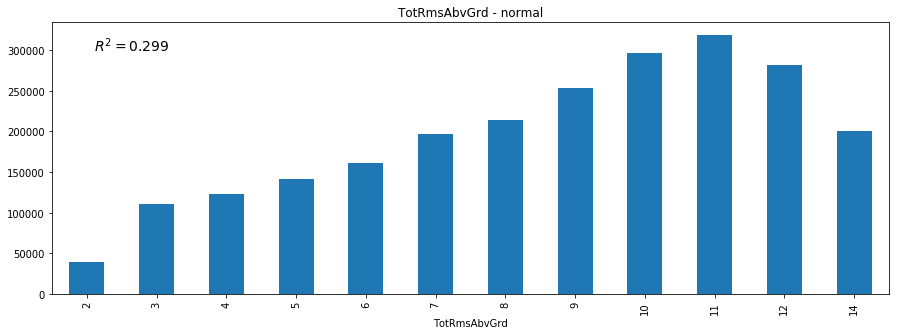

Functional


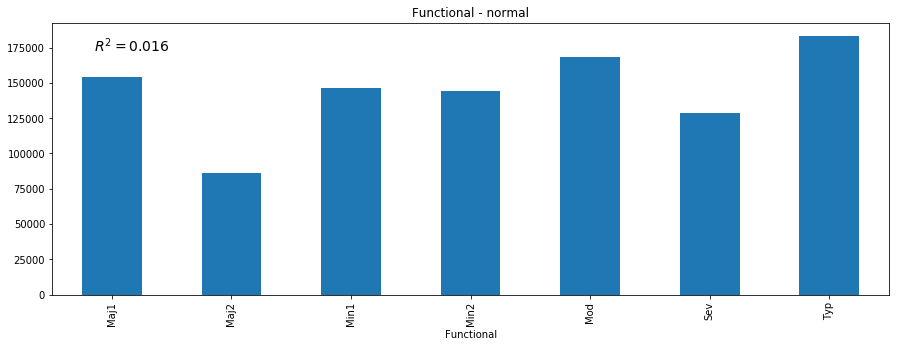

Fireplaces


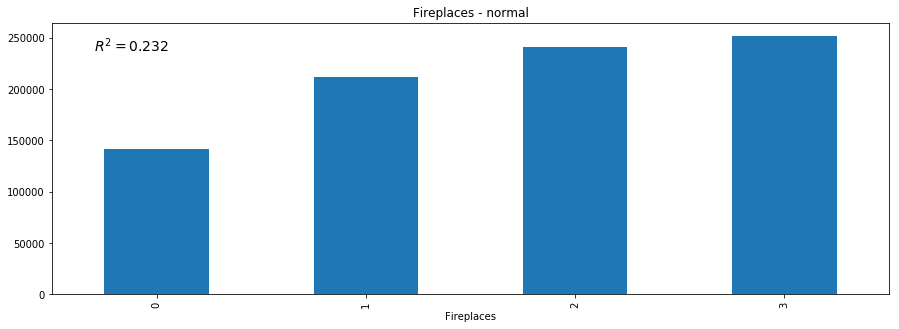

FireplaceQu


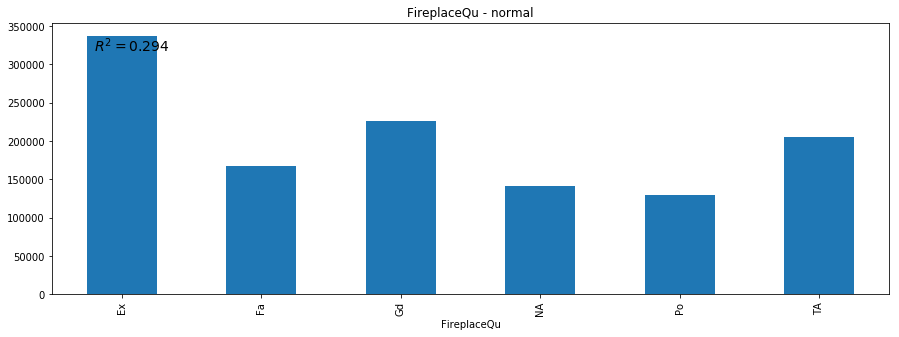

GarageType


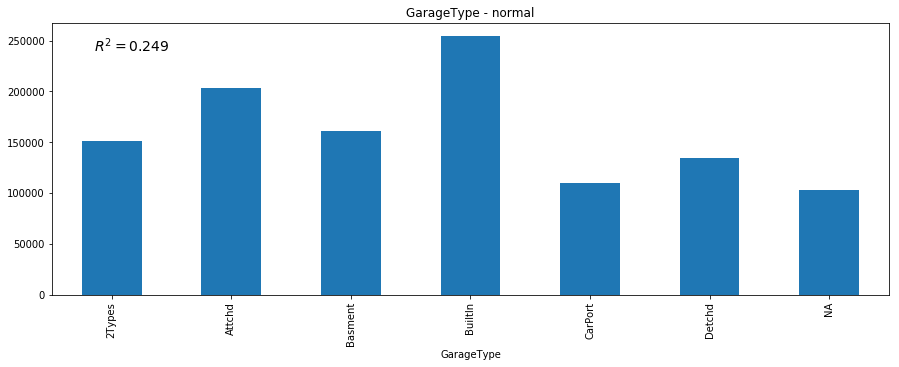

GarageFinish


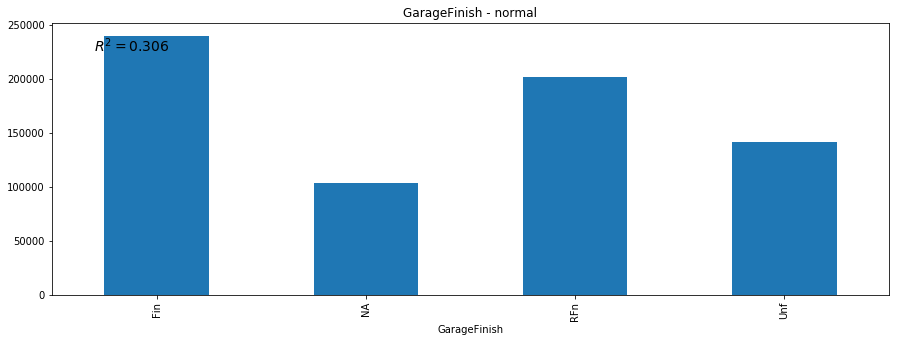

GarageCars


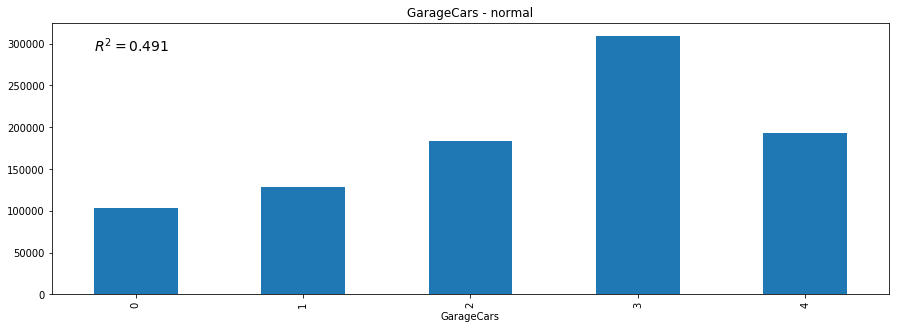

GarageQual


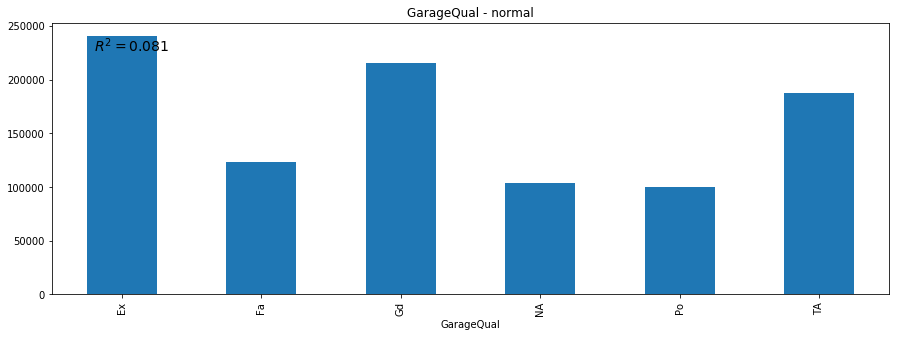

GarageCond


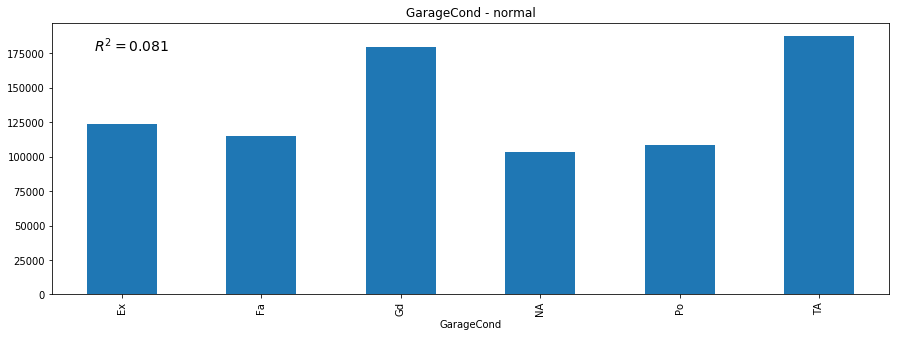

PavedDrive


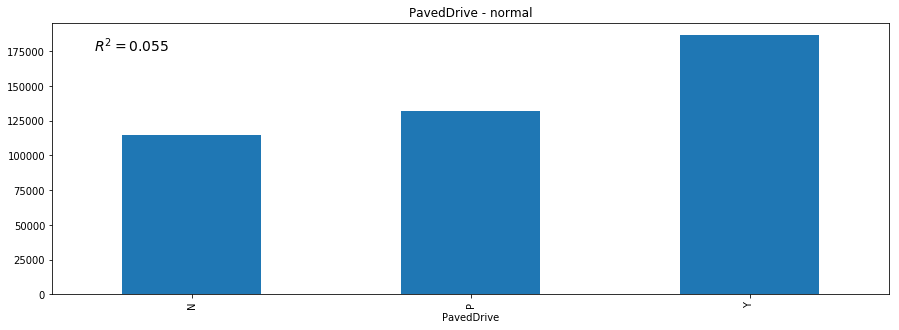

PoolQC


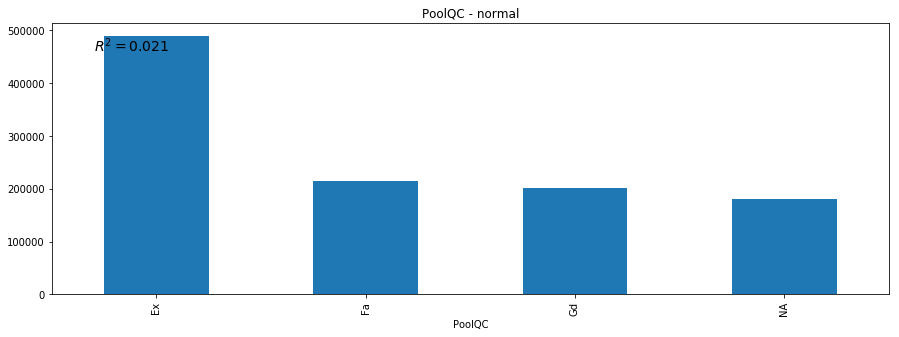

Fence


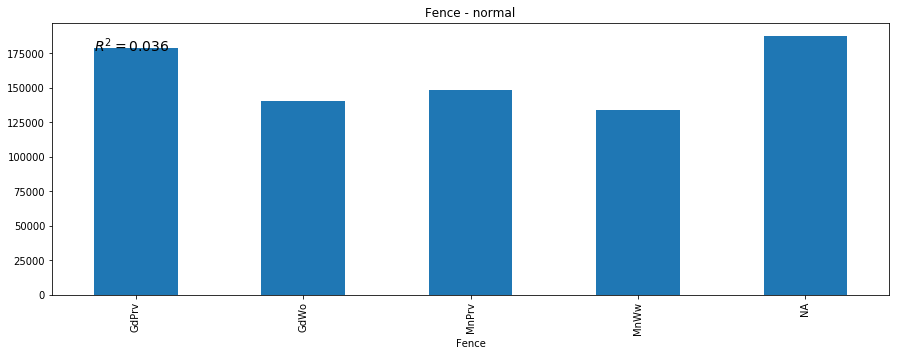

MiscFeature


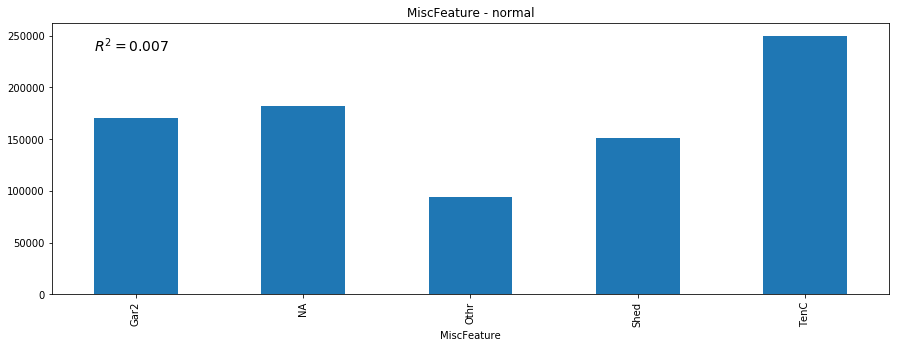

MoSold


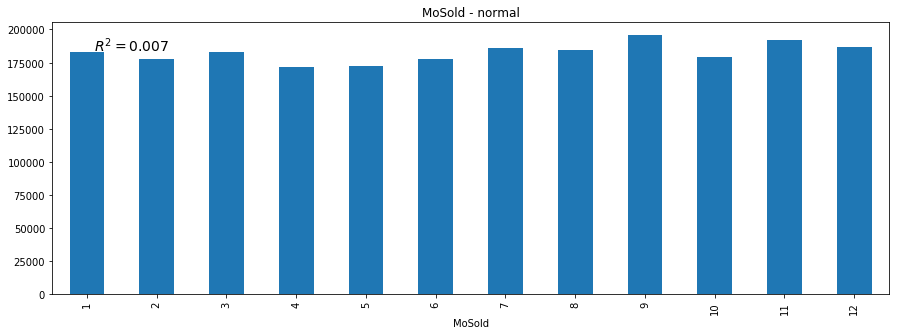

SaleType


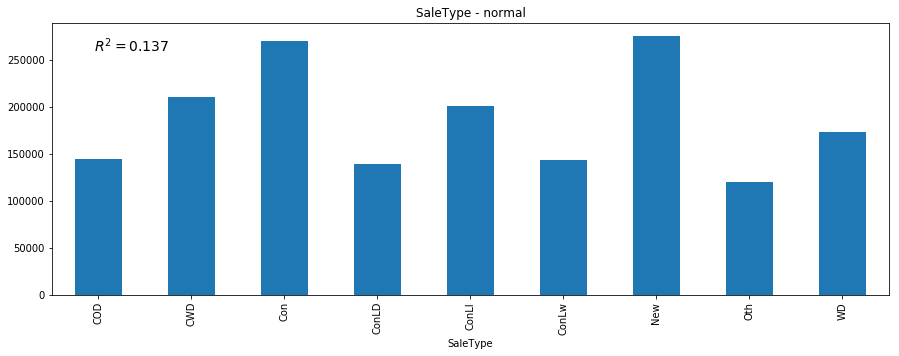

SaleCondition


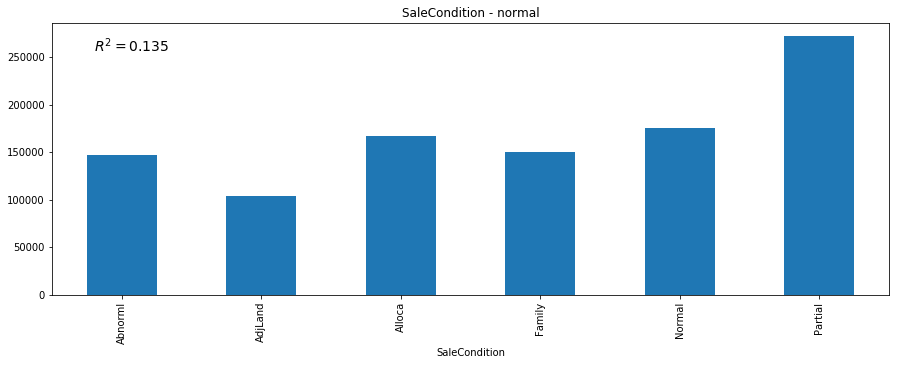

In [10]:
# Plot variable overview for all categorical variables
category_variables_r2 = []

for variable_to_plot in categorical_variables:
    print(variable_to_plot)
    normal_r2 = plot_categorical_variable(raw_data,x_variable=variable_to_plot)
    
    category_variables_r2.append([variable_to_plot, normal_r2])
    
category_overview = pd.DataFrame(category_variables_r2, columns=["variable", "R2"])

## Data transformation function

In [11]:
# Create the function that cleane the data

# RefId will not be used in the training but shall be used to identify the data
data_identifier_name = "Id" #An unique ID are not a good predictor
dependent_variable = "SalePrice"
dependent_variable_ln = dependent_variable + "_ln"

# functionality to drop/keep variables
drop_variables = True # A indicator if variable shall be dropped or kept in the data_cleaning
columns_to_drop = [] #['Alley', 'PoolQC', 'YrSold' ]
independent_columns_to_keep = [] # excluding id variable and dependent variable

# missing values inference
default_values_for_all_missing_continous_variables = True
missing_variables_to_fix = []


# functionality to create missing variables based on the average ratio between 2 variables
scale_functoinality_disabled = True
prices_to_scale = [
                    " TBU"
                    ]

price_to_scale_with = 'TBU'


def drop_variables(data_to_transform, columns_to_drop = [], independent_columns_to_keep = []):
    '''
    Drop the non needed columns
    '''
    # Todo: Update
    if True: #columns_to_drop:
        return data_to_transform.drop(columns_to_drop, axis = 1)
    else:
        independent_columns_to_keep.append(data_identifier_name)
        independent_columns_to_keep.append(dependent_variable)

        
def fix_missing_continous_variables(data_to_transform, contionus_variables, variables_to_impute = []):
    '''
    Fix missing continous variables by assigning the median value
    '''        
    for col in variables_to_impute:
        data_to_transform[col].fillna(data_to_transform[col].median())
        
    for col in contionus_variables:
        x_raw = data_to_transform[col].copy()
        x_raw.loc[x_raw=="NA"] = 0.0
        x_fixed = x_raw.fillna(0).astype(float)
        data_to_transform.loc[:,col] = x_fixed
        
    return data_to_transform
    
    
def calculate_scaled_prices(data_to_transform, price_to_scale_with, prices_to_scale):
    average_price_to_scale = data_to_transform[prices_to_scale].mean()
    average_price_to_scale_with = data_to_transform[price_to_scale_with].mean()
    
    scale_factors = average_price_to_scale / average_price_to_scale_with
    
    for price_name in prices_to_scale:
        data_to_transform.loc[data_to_transform[price_name].isnull(), price_name] = data_to_transform[
            price_to_scale_with] * scale_factors[price_name]
        
    return data_to_transform


def calculate_price_ratios(data_to_transform, price_to_scale_with, prices_to_scale):
    '''
    Function that calculates the ratio between the different prices and the saleprice
    '''
    for price_variable in prices_to_scale:
        data_to_transform[price_variable + "_ratio"] = data_to_transform[
            price_variable]/data_to_transform[price_to_scale_with]
    
    return data_to_transform



def group_and_fix_missing_values_categorical_var(data_to_transform, categorical_variables = [], aggrigation_cut_off = 10):
    '''
    Simple function to fill out missing data for the categorical funtions and to 
    group variables with less than XX entries together to create a less wide data 
    set when dummy variables are created
    '''
    for variable in categorical_variables:
        # replace missing values with OTHER
        data_to_transform.loc[:, variable] = data_to_transform[variable].astype("category")
        data_to_transform.loc[data_to_transform[variable].isnull(), variable] = "OTHER"
        
        # group the variables together and replace the non frequent variables with OTHER
        variables_to_not_transform = (raw_data[variable].value_counts()>aggrigation_cut_off).index
        data_to_transform.loc[data_to_transform[variable].isin(variables_to_not_transform) == False, variable] = "OTHER"
     
    return data_to_transform


# TODO: fix create dummies funciton
def create_dummy_variables(data_to_transform, categorical_variables_to_keep, continous_variables_to_keep):
    
    # We now create dummy variables for the categorical variables
    data_continous = data_to_transform[continous_variables_to_keep]
    data_categorical = data_to_transform[categorical_variables_to_keep]

    #looping over the categorical variables and make them to "category" types
    for column in data_categorical.columns:
        data_categorical[column] = data_categorical[column].astype("category")

    # create dummy variables
    car_dummies = pd.get_dummies(data_categorical, drop_first=True)

    # create final data set
    merged_data = car_dummies.merge(data_continous, left_index=True, right_index=True, how='inner')
    
    return merged_data


def add_calculated_continous_variables(full_data_for_scaling):
    
    def help_calculate(data):
        """
        Help function that defines the transformation that shall be done
        """
        data.loc[:, "totalAreaSF"] = data["1stFlrSF"] + data["2ndFlrSF"]
        data.loc[:, "totalPoarchAreaSF"] = data["WoodDeckSF"] + data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]
        
        return data
    
    return help_calculate(full_data_for_scaling)


def transform_dependent_variable(full_data_for_scaling, dependent_variable):
    
    full_data_for_scaling[dependent_variable_ln] = np.log(full_data_for_scaling[dependent_variable])
    
    return full_data_for_scaling, dependent_variable_ln
        


def data_cleaning_transformations(train_data, test_data, transform_dependent_variable_bool=False):
    
    id_train = train_data[data_identifier_name]
    id_test = test_data[data_identifier_name]
    
    full_data_for_scaling = pd.concat([train_data, test_data]).reset_index(drop=True)
    
    # Drop unnecicary data
    full_data_for_scaling = drop_variables(full_data_for_scaling, 
                                           columns_to_drop = columns_to_drop, 
                                           independent_columns_to_keep = independent_columns_to_keep)
    
    # Calculate the scaled prices
    if scale_functoinality_disabled == False:
        full_data_for_scaling = calculate_scaled_prices(full_data_for_scaling, price_to_scale_with, prices_to_scale)
        full_data_for_scaling = calculate_price_ratios(full_data_for_scaling, price_to_scale_with, prices_to_scale)
        
    # Fixing the missing values
    full_data_for_scaling = fix_missing_continous_variables(full_data_for_scaling, 
                                                            continous_variables,
                                                            variables_to_impute = [])
    full_data_for_scaling = group_and_fix_missing_values_categorical_var(full_data_for_scaling)
    
    if transform_dependent_variable_bool:
        full_data_for_scaling, dependent_variable_updated = transform_dependent_variable(full_data_for_scaling, dependent_variable)
    else:
        dependent_variable_updated = dependent_variable
    
    # Todo: Update with only selected data for dummy creation (group dummies)
    # Todo: Make sure that this is updated with continous variables
    # now create the dummy variables and drop the variables that is not needed 
    continous_variables_to_keep = continous_variables + [data_identifier_name, dependent_variable_updated]
    categorical_variables_to_keep = categorical_variables
    
    full_data_for_scaling = create_dummy_variables(full_data_for_scaling,
                                                   categorical_variables_to_keep,
                                                   continous_variables_to_keep)
    
    full_data_for_scaling = add_calculated_continous_variables(full_data_for_scaling)
    
    # split the data back to train and test data
    train_data = full_data_for_scaling.loc[full_data_for_scaling[data_identifier_name].isin(id_train)].reset_index(drop=True)
    test_data = full_data_for_scaling.loc[full_data_for_scaling[data_identifier_name].isin(id_test)].reset_index(drop=True)
    
    return train_data, test_data, id_test, dependent_variable_updated
    

In [12]:
train_data, test_data, id_test, dependent_variable = data_cleaning_transformations(raw_data, raw_data_test)

print(train_data.shape)
print(test_data.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1460, 361)
(1459, 361)


## Train the model

### Create training split of data

In [13]:
# Get the dependent variable data
dv_data = train_data[dependent_variable]

# Create the independent variable dataframe that has all columns except for loan_approval_status
iv_data = train_data.drop(dependent_variable, axis=1)

# Create the test and train data sets
X_train, X_test, y_train, y_test = train_test_split(iv_data, dv_data, test_size=0.25)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1095, 360) (1095,)
(365, 360) (365,)


### First training iteration of model

Start training LinearRegression
Training score: 39360.119148618374
Stop training LinearRegression. Time taken 6.637465953826904 s
Start training RandomForestRegressor
Training score: 33090.89372847624
Stop training RandomForestRegressor. Time taken 18.994285106658936 s
Start training GradientBoostingRegressor
Training score: 31621.537534696843
Stop training GradientBoostingRegressor. Time taken 70.03921699523926 s
Start training KNeighborsRegressor
Training score: 47173.16480266328
Stop training KNeighborsRegressor. Time taken 1.1403934955596924 s
Start training MLPRegressor
Training score: 48589.63763757693
Stop training MLPRegressor. Time taken 21.87901496887207 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,GradientBoostingRegressor,RandomForestRegressor,LinearRegression,KNeighborsRegressor,MLPRegressor
0,31621.537535,33090.893728,39360.119149,47173.164803,48589.637638


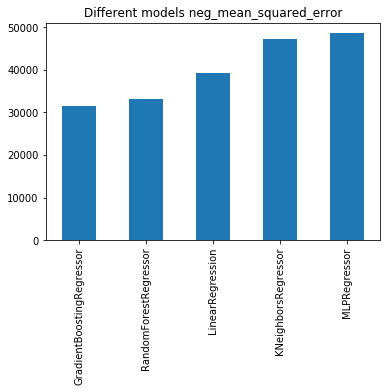

In [14]:
# Test multiple funcitons with GridSearchCV
# This method needs X_train and Y_train to be 

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

models_to_train = [LinearRegression(),
                  RandomForestRegressor(),
                  ensemble.GradientBoostingRegressor(learning_rate=0.1, loss="ls"),
                  KNeighborsRegressor(),
                   MLPRegressor()]

model_names = ['LinearRegression',
               "RandomForestRegressor",
               "GradientBoostingRegressor",
               "KNeighborsRegressor",
               "MLPRegressor"
              ]

best_models = {}
best_model_mean_squared_error = []

parameters = {
    'LinearRegression':{
        'normalize':[False]
             },
    "RandomForestRegressor":{
        "n_estimators": [10, 50, 100],
        "max_depth": [3, 5, 8],
        "min_samples_split": [2, 3, 5],
    },
    "GradientBoostingRegressor": {
            "n_estimators": [50, 100, 200],
            "max_depth": [2, 5, 8],
            "min_samples_split": [2, 3, 5],
        },
    "KNeighborsRegressor": {
            "n_neighbors": [1, 3, 5],
            "weights": ["uniform", "distance"],
        },
    
    "MLPRegressor":{
            "hidden_layer_sizes": [(10, 15, 10, 5)],
            "alpha": [0.0001, 0.001],
            "learning_rate": ["constant"],
            "max_iter": [200, 500],
        }
    }

# Find out the best model
for i in range(0,len(model_names)):
    
    
    act_model = models_to_train[i]
    act_model_name = model_names[i]
    print("Start training " + act_model_name)
    
    # Get the start time
    start_time = time.time()
    
    act_params = parameters[act_model_name]
    
    act_model = GridSearchCV(act_model, act_params, cv=5, scoring=scoring_func, n_jobs = N_JOBS)
    act_model.fit(X_train, y_train)
    print("Training score: {}".format(act_model.best_score_ *-1))

    act_best_model = act_model.best_estimator_
    best_models[act_model_name] = act_best_model
    
    #best_model_mean_squared_error.append(np.sqrt(mean_squared_error(np.log(y_train), np.log(act_best_model.predict(X_train)))))
    best_model_mean_squared_error.append(-1 * act_model.best_score_)
    
    # get the end time
    time_taken = time.time() - start_time
    print("Stop training " + act_model_name + ". Time taken {} s".format(time_taken))

# displaying the results
result_df = pd.DataFrame(best_model_mean_squared_error).T
result_df.columns = model_names
result_df = result_df[result_df.iloc[-1].sort_values(ascending=True).index]

result_df.T.plot(kind='bar', title = "Different models " + SCORING_METRIC, legend = False )
result_df.head()

#### Todo
* Add a sample size insample/out of sample graph to show overfitting

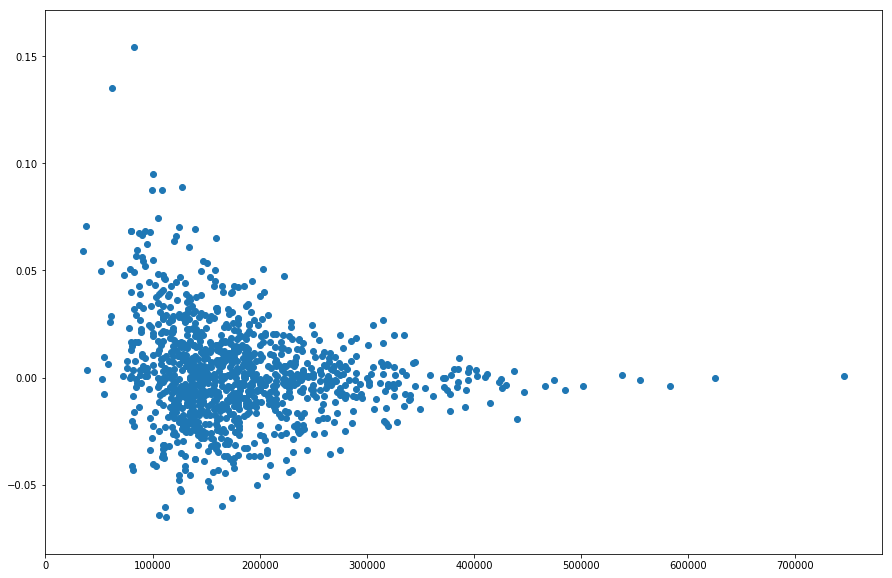

In [27]:
# Plot the errors vs the Sales price

act_model = best_models["GradientBoostingRegressor"]

errors = act_model.predict(X_train) - y_train

ln_errors = np.log(act_model.predict(X_train)) - np.log(y_train)

plt.figure(figsize=(15,10))
plt.scatter(y_train, ln_errors)

### Best model hyper parameter refinement
* Take the values from the hyperparameter fitting from above and select the best combination of hyper parameters

In [16]:
# Todo: select hyperparameter selection
best_models["GradientBoostingRegressor"]

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
# Get the start time
start_time = time.time()

parameters =  {
            "n_estimators": [200, 500, 1000],
            "max_depth": [1, 2, 3],
            "min_samples_split": [2, 3],
            "learning_rate": [0.05, 0.1, 0.15]
        }

selected_model = ensemble.GradientBoostingRegressor(loss="ls")


selected_GS = GridSearchCV(selected_model, parameters, cv=5, scoring=scoring_func, n_jobs = N_JOBS)
selected_GS.fit(X_train, y_train)
print("Training score: {}".format(selected_GS.best_score_ *-1))

# get the end time
time_taken = time.time() - start_time
print("Stop training " + act_model_name + ". Time taken {} s".format(time_taken))

selected_best_model = selected_GS.best_estimator_
selected_best_model

Training score: 31607.04228186589
Stop training MLPRegressor. Time taken 138.502099275589 s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
# Todo: create additional itteration with best selected model
# Get the start time
start_time = time.time()

parameters =  {
            "n_estimators": [750, 1000, 1500],
            "max_depth": [2],
            "min_samples_split": [2, 3],
            "learning_rate": [0.1]
        }

selected_model_2 = ensemble.GradientBoostingRegressor(loss="ls")


selected_GS_2 = GridSearchCV(selected_model_2, parameters, cv=5, scoring=scoring_func, n_jobs = N_JOBS)
selected_GS_2.fit(X_train, y_train)
print("Training score: {}".format(selected_GS_2.best_score_ *-1))

# get the end time
time_taken = time.time() - start_time
print("Stop training " + act_model_name + ". Time taken {} s".format(time_taken))

selected_best_model_2 = selected_GS_2.best_estimator_
selected_best_model_2

Training score: 32972.381281334885
Stop training MLPRegressor. Time taken 38.12771511077881 s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
# Finally train the model with all training data
learning_rate = 0.1,
max_depth = 2
min_sample_split=2
n_estimators=750

final_model = ensemble.GradientBoostingRegressor(
    loss="ls",
    learning_rate = learning_rate,
    max_depth = max_depth,
    min_sample_split = min_sample_split,
    n_estimators = n_estimators
                                                 
                                                )

TypeError: __init__() got an unexpected keyword argument 'min_sample_split'

## Output creation
* Create output for submission to Kaggle competition

In [ ]:
# Create output directory
base_path = os.path.dirname(os.getcwd())
file_path = os.path.join(base_path, "output_data")

if not os.path.exists(file_path):
    os.makedirs(file_path)

file_name = "submission_v2.csv"

test_predictions = final_model.predict(test_data.drop(dependent_variable, axis=1))

test_predictions_df = pd.DataFrame({"Id":id_test, "SalePrice":test_predictions})

test_predictions_df.to_csv(os.path.join(file_path,file_name), sep = ",", index=False)

test_predictions_df.head()